In [2]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm


from statsmodels.tsa.stattools import kpss
from plotnine import *

# Load the datasets
missing_tooth = pd.read_csv('missing_tooth.csv')
tooth_chipped = pd.read_csv('tooth_chipped_fault.csv')
surface_fault = pd.read_csv('surface_fault.csv')
no_fault = pd.read_csv('no_fault.csv')
root_crack = pd.read_csv('root_crack.csv')
eccentricity = pd.read_csv('eccentricity.csv')

In [3]:
no_fault.speedSet.value_counts()

speedSet
8.332031     50000
25.000000    50000
40.000000    50000
Name: count, dtype: int64

In [4]:
no_fault.load_value.value_counts()


load_value
0     75000
80    75000
Name: count, dtype: int64

In [5]:
missing_tooth['state'] = 'missing_tooth'
tooth_chipped['state'] = 'tooth_chipped'
surface_fault['state'] = 'surface_fault'
no_fault['state'] = 'no_fault'
root_crack['state'] = 'root_crack'
eccentricity['state'] = 'eccentricity'

df = pd.concat([
    missing_tooth, 
    tooth_chipped,
    surface_fault,
    no_fault,
    root_crack, 
    eccentricity
])
display(df.info())
#Normalize time_x grouped by state, load_value, speedSet
df['time_x'] = pd.to_datetime(df['time_x'])
df['time_normalized'] = df.groupby(['state', 'load_value', 'speedSet'])['time_x'].transform(lambda x: (x - x.min()).dt.total_seconds())

df['time_normalized']


<class 'pandas.core.frame.DataFrame'>
Index: 900000 entries, 0 to 149999
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   sensor1          900000 non-null  float64
 1   sensor2          900000 non-null  float64
 2   time_x           900000 non-null  object 
 3   speedSet         900000 non-null  float64
 4   load_value       900000 non-null  int64  
 5   gear_fault_desc  900000 non-null  object 
 6   state            900000 non-null  object 
dtypes: float64(3), int64(1), object(3)
memory usage: 54.9+ MB


None

0         0.0000
1         0.0002
2         0.0004
3         0.0006
4         0.0008
           ...  
149995    4.9990
149996    4.9992
149997    4.9994
149998    4.9996
149999    4.9998
Name: time_normalized, Length: 900000, dtype: float64

In [6]:
df.drop(columns='time_normalized').describe()

,sensor1,sensor2,time_x,speedSet,load_value
count,900000.000000,900000.000000,900000,900000.000000,900000.000000
mean,2.519877,2.429291,2023-05-03 13:39:41.138789376,24.444010,40.000000
min,2.219428,2.161939,2023-05-02 10:30:01,8.332031,0.000000
25%,2.516895,2.426390,2023-05-02 16:02:08.249949952,8.332031,0.000000
50%,2.520180,2.429839,2023-05-03 13:54:29.499899904,25.000000,40.000000
75%,2.522972,2.432303,2023-05-03 20:28:31.249850112,40.000000,80.000000
max,2.820934,2.709896,2023-05-07 17:11:48.999800,40.000000,80.000000
std,0.011236,0.012001,NaN,12.934378,40.000022


In [7]:
df['time_formatted'] = pd.to_datetime(df.time_x, format="%Y-%m-%d %H:%M:%S.%f")

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 900000 entries, 0 to 149999
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   sensor1          900000 non-null  float64       
 1   sensor2          900000 non-null  float64       
 2   time_x           900000 non-null  datetime64[ns]
 3   speedSet         900000 non-null  float64       
 4   load_value       900000 non-null  int64         
 5   gear_fault_desc  900000 non-null  object        
 6   state            900000 non-null  object        
 7   time_normalized  900000 non-null  float64       
 8   time_formatted   900000 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(4), int64(1), object(2)
memory usage: 68.7+ MB


In [9]:
df.state.value_counts()

state
missing_tooth    150000
tooth_chipped    150000
surface_fault    150000
no_fault         150000
root_crack       150000
eccentricity     150000
Name: count, dtype: int64

In [10]:
df.state.unique()

array(['missing_tooth', 'tooth_chipped', 'surface_fault', 'no_fault',
       'root_crack', 'eccentricity'], dtype=object)

In [11]:
df['sensor1_max_exp'] = df.groupby(['state', 'load_value', 'speedSet']).sensor1.transform(lambda x: x.expanding().max())
df['sensor1_min_exp'] = df.groupby(['state', 'load_value', 'speedSet']).sensor1.transform(lambda x: x.expanding().min())

df['sensor2_max_exp'] = df.groupby(['state', 'load_value', 'speedSet']).sensor2.transform(lambda x: x.expanding().max())
df['sensor2_min_exp'] = df.groupby(['state', 'load_value', 'speedSet']).sensor2.transform(lambda x: x.expanding().min())

df['sensor1_mean_exp'] = df.groupby(['state', 'load_value', 'speedSet']).sensor1.transform(lambda x: x.expanding().mean())
df['sensor2_mean_exp'] = df.groupby(['state', 'load_value', 'speedSet']).sensor2.transform(lambda x: x.expanding().mean())

df['sensor1_std_exp'] = df.groupby(['state', 'load_value', 'speedSet']).sensor1.transform(lambda x: x.expanding().std())
df['sensor2_std_exp'] = df.groupby(['state', 'load_value', 'speedSet']).sensor2.transform(lambda x: x.expanding().std())

In [12]:
speedload_8_0 = df[df.state.isin(['missing_tooth', 'tooth_chipped', 'surface_fault', 'no_fault', 'root_crack', 'eccentricity']) 
                        & (df.speedSet == 8.33203125) & (df.load_value == 0)].copy()
speedload_8_80 = df[df.state.isin(['missing_tooth', 'tooth_chipped', 'surface_fault', 'no_fault', 'root_crack', 'eccentricity']) 
                        & (df.speedSet == 8.33203125) & (df.load_value == 80)].copy()
speedload_25_0 = df[df.state.isin(['missing_tooth', 'tooth_chipped', 'surface_fault', 'no_fault', 'root_crack', 'eccentricity'])
                        & (df.speedSet == 25) & (df.load_value == 0)].copy()
speedload_25_80 = df[df.state.isin(['missing_tooth', 'tooth_chipped', 'surface_fault', 'no_fault', 'root_crack', 'eccentricity'])       
                        & (df.speedSet == 25) & (df.load_value == 80)].copy()
speedload_40_0 = df[df.state.isin(['missing_tooth', 'tooth_chipped', 'surface_fault', 'no_fault', 'root_crack', 'eccentricity'])
                        & (df.speedSet == 40) & (df.load_value == 0)].copy()
speedload_40_80 = df[df.state.isin(['missing_tooth', 'tooth_chipped', 'surface_fault', 'no_fault', 'root_crack', 'eccentricity'])
                        & (df.speedSet == 40) & (df.load_value == 80)].copy()

# Define your custom color palette
colors = ['#E41A1C', '#377EB8', '#4DAF4A', '#984EA3', '#FF7F00', '#FFFF33']
"""        
display(ggplot(data = speedload_8_0, mapping = aes(x = 'sensor1', fill = 'state')) + geom_density(alpha = 0.3) + stat_ecdf() +
        scale_fill_manual(values=colors) + ggtitle('Rýchlosť 8.33, záťaž 0') + xlim(2.51, 2.53))
display(ggplot(data = speedload_8_80, mapping = aes(x = 'sensor1', fill = 'state')) + geom_density(alpha = 0.3) + stat_ecdf() +
        scale_fill_manual(values=colors) + ggtitle('Rýchlosť 8.33, záťaž 80') + xlim(2.5, 2.535))
display(ggplot(data = speedload_25_0, mapping = aes(x = 'sensor1', fill = 'state')) + geom_density(alpha = 0.3) + stat_ecdf() +
        scale_fill_manual(values=colors) + ggtitle('Rýchlosť 25, záťaž 0') + xlim(2.45, 2.59))
display(ggplot(data = speedload_25_80, mapping = aes(x = 'sensor1', fill = 'state')) + geom_density(alpha = 0.3) + stat_ecdf() +
        scale_fill_manual(values=colors) + ggtitle('Rýchlosť 25, záťaž 80') + xlim(2.41, 2.61))
display(ggplot(data = speedload_40_0, mapping = aes(x = 'sensor1', fill = 'state')) + geom_density(alpha = 0.3) + stat_ecdf() +
        scale_fill_manual(values=colors) + ggtitle('Rýchlosť 40, záťaž 0') + xlim(2.45, 2.57))
display(ggplot(data = speedload_40_80, mapping = aes(x = 'sensor1', fill = 'state')) + geom_density(alpha = 0.3) + stat_ecdf() +
        scale_fill_manual(values=colors) + ggtitle('Rýchlosť 40, záťaž 80') + xlim(2.4, 2.62))
# I need to narrow the x-axis range to see the differences better

display(ggplot(data = speedload_8_80, mapping = aes(x = 'sensor1', fill = 'state')) + geom_density(alpha = 0.3)+ stat_ecdf() +
        scale_fill_manual(values=colors) + ggtitle('Rýchlosť 8.33, záťaž 80'))
display(ggplot(data = speedload_25_0, mapping = aes(x = 'sensor1', fill = 'state')) + geom_density(alpha = 0.3)+ stat_ecdf() +
        scale_fill_manual(values=colors) + ggtitle('Rýchlosť 25, záťaž 0'))
display(ggplot(data = speedload_25_80, mapping = aes(x = 'sensor1', fill = 'state')) + geom_density(alpha = 0.3)+ stat_ecdf() +
        scale_fill_manual(values=colors) + ggtitle('Rýchlosť 25, záťaž 80'))
display(ggplot(data = speedload_40_0, mapping = aes(x = 'sensor1', fill = 'state')) + geom_density(alpha = 0.3)+ stat_ecdf() +
        scale_fill_manual(values=colors) + ggtitle('Rýchlosť 40, záťaž 0'))
display(ggplot(data = speedload_40_80, mapping = aes(x = 'sensor1', fill = 'state')) + geom_density(alpha = 0.3)+ stat_ecdf() +
        scale_fill_manual(values=colors) + ggtitle('Rýchlosť 40, záťaž 80'))
"""


"        \ndisplay(ggplot(data = speedload_8_0, mapping = aes(x = 'sensor1', fill = 'state')) + geom_density(alpha = 0.3) + stat_ecdf() +\n        scale_fill_manual(values=colors) + ggtitle('Rýchlosť 8.33, záťaž 0') + xlim(2.51, 2.53))\ndisplay(ggplot(data = speedload_8_80, mapping = aes(x = 'sensor1', fill = 'state')) + geom_density(alpha = 0.3) + stat_ecdf() +\n        scale_fill_manual(values=colors) + ggtitle('Rýchlosť 8.33, záťaž 80') + xlim(2.5, 2.535))\ndisplay(ggplot(data = speedload_25_0, mapping = aes(x = 'sensor1', fill = 'state')) + geom_density(alpha = 0.3) + stat_ecdf() +\n        scale_fill_manual(values=colors) + ggtitle('Rýchlosť 25, záťaž 0') + xlim(2.45, 2.59))\ndisplay(ggplot(data = speedload_25_80, mapping = aes(x = 'sensor1', fill = 'state')) + geom_density(alpha = 0.3) + stat_ecdf() +\n        scale_fill_manual(values=colors) + ggtitle('Rýchlosť 25, záťaž 80') + xlim(2.41, 2.61))\ndisplay(ggplot(data = speedload_40_0, mapping = aes(x = 'sensor1', fill = 'state'))

In [13]:
# Calculate the avarage column for sensor1 and sensor2 values in time for speedLoad 8.33 and 0 and then the other combinations
speedload_8_0['sensor1_avg'] = speedload_8_0.groupby(['state', 'load_value', 'speedSet']).sensor1.transform(lambda x: x.expanding().mean())
speedload_8_0['sensor2_avg'] = speedload_8_0.groupby(['state', 'load_value', 'speedSet']).sensor2.transform(lambda x: x.expanding().mean())
speedload_8_80['sensor1_avg'] = speedload_8_80.groupby(['state', 'load_value', 'speedSet']).sensor1.transform(lambda x: x.expanding().mean())
speedload_8_80['sensor2_avg'] = speedload_8_80.groupby(['state', 'load_value', 'speedSet']).sensor2.transform(lambda x: x.expanding().mean())
speedload_25_0['sensor1_avg'] = speedload_25_0.groupby(['state', 'load_value', 'speedSet']).sensor1.transform(lambda x: x.expanding().mean())
speedload_25_0['sensor2_avg'] = speedload_25_0.groupby(['state', 'load_value', 'speedSet']).sensor2.transform(lambda x: x.expanding().mean())
speedload_25_80['sensor1_avg'] = speedload_25_80.groupby(['state', 'load_value', 'speedSet']).sensor1.transform(lambda x: x.expanding().mean())
speedload_25_80['sensor2_avg'] = speedload_25_80.groupby(['state', 'load_value', 'speedSet']).sensor2.transform(lambda x: x.expanding().mean())
speedload_40_0['sensor1_avg'] = speedload_40_0.groupby(['state', 'load_value', 'speedSet']).sensor1.transform(lambda x: x.expanding().mean())
speedload_40_0['sensor2_avg'] = speedload_40_0.groupby(['state', 'load_value', 'speedSet']).sensor2.transform(lambda x: x.expanding().mean())
speedload_40_80['sensor1_avg'] = speedload_40_80.groupby(['state', 'load_value', 'speedSet']).sensor1.transform(lambda x: x.expanding().mean())
speedload_40_80['sensor2_avg'] = speedload_40_80.groupby(['state', 'load_value', 'speedSet']).sensor2.transform(lambda x: x.expanding().mean())


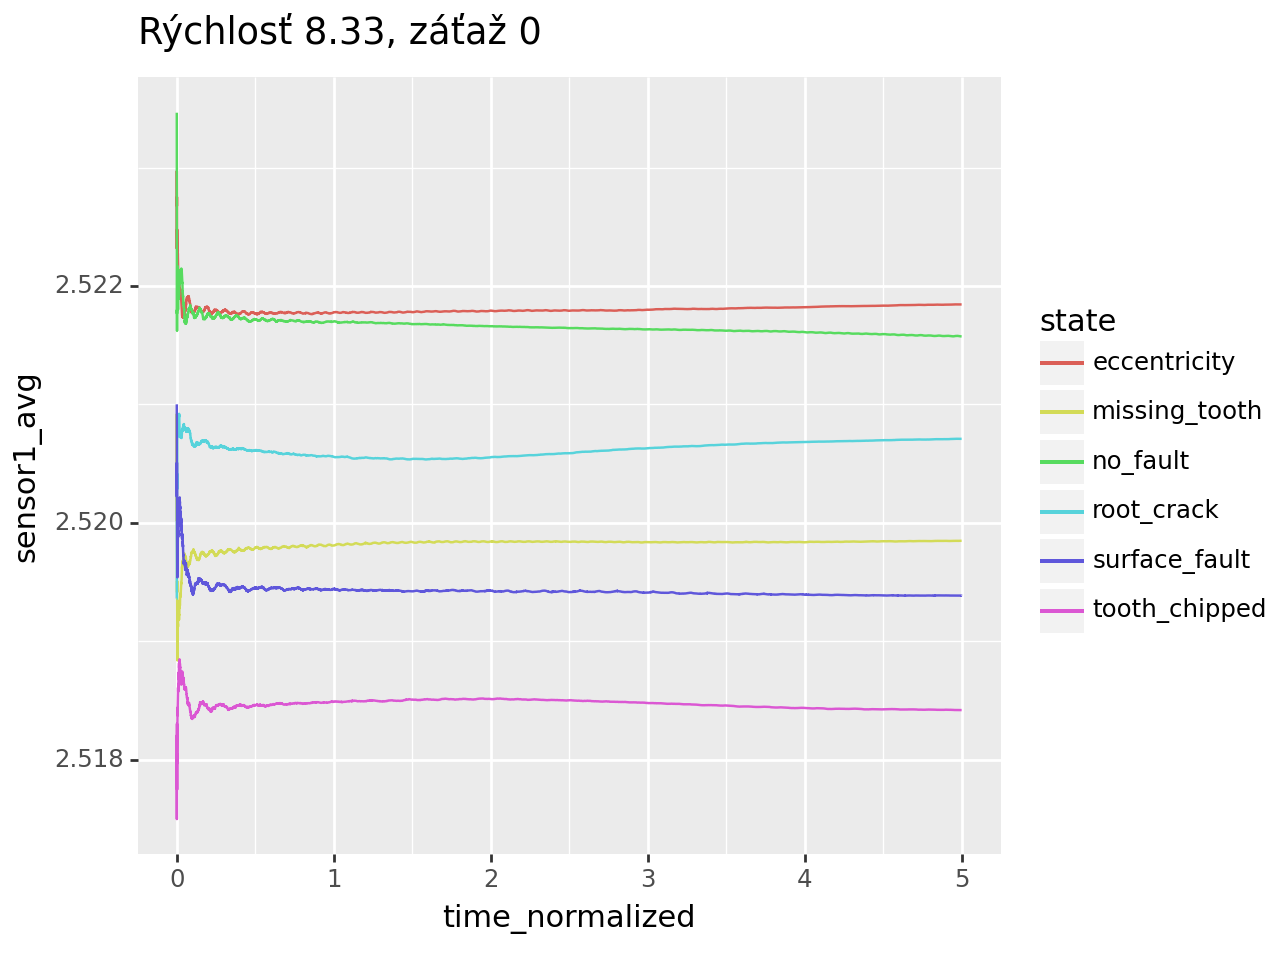

<Figure Size: (640 x 480)>

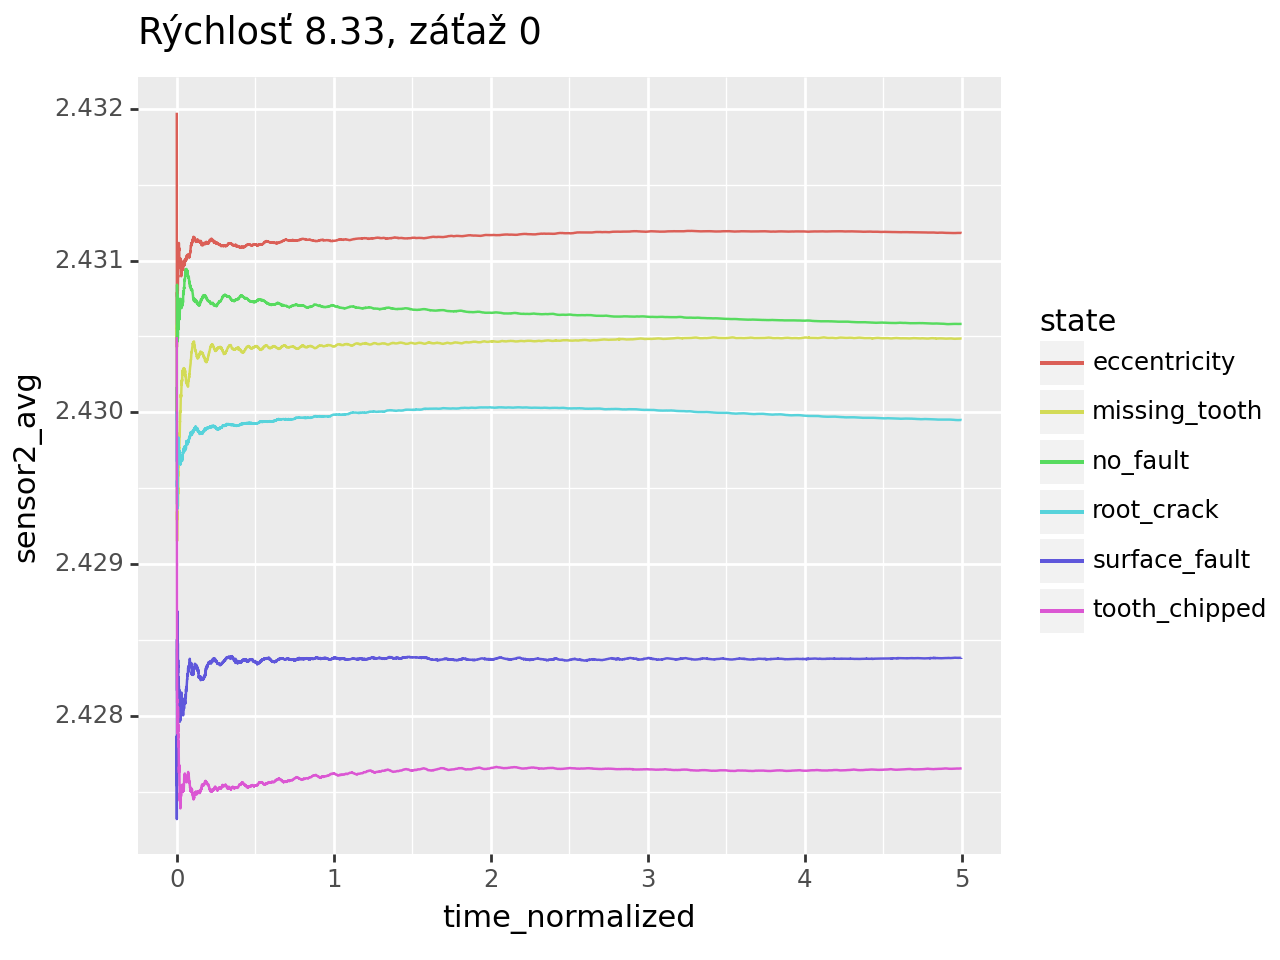

<Figure Size: (640 x 480)>

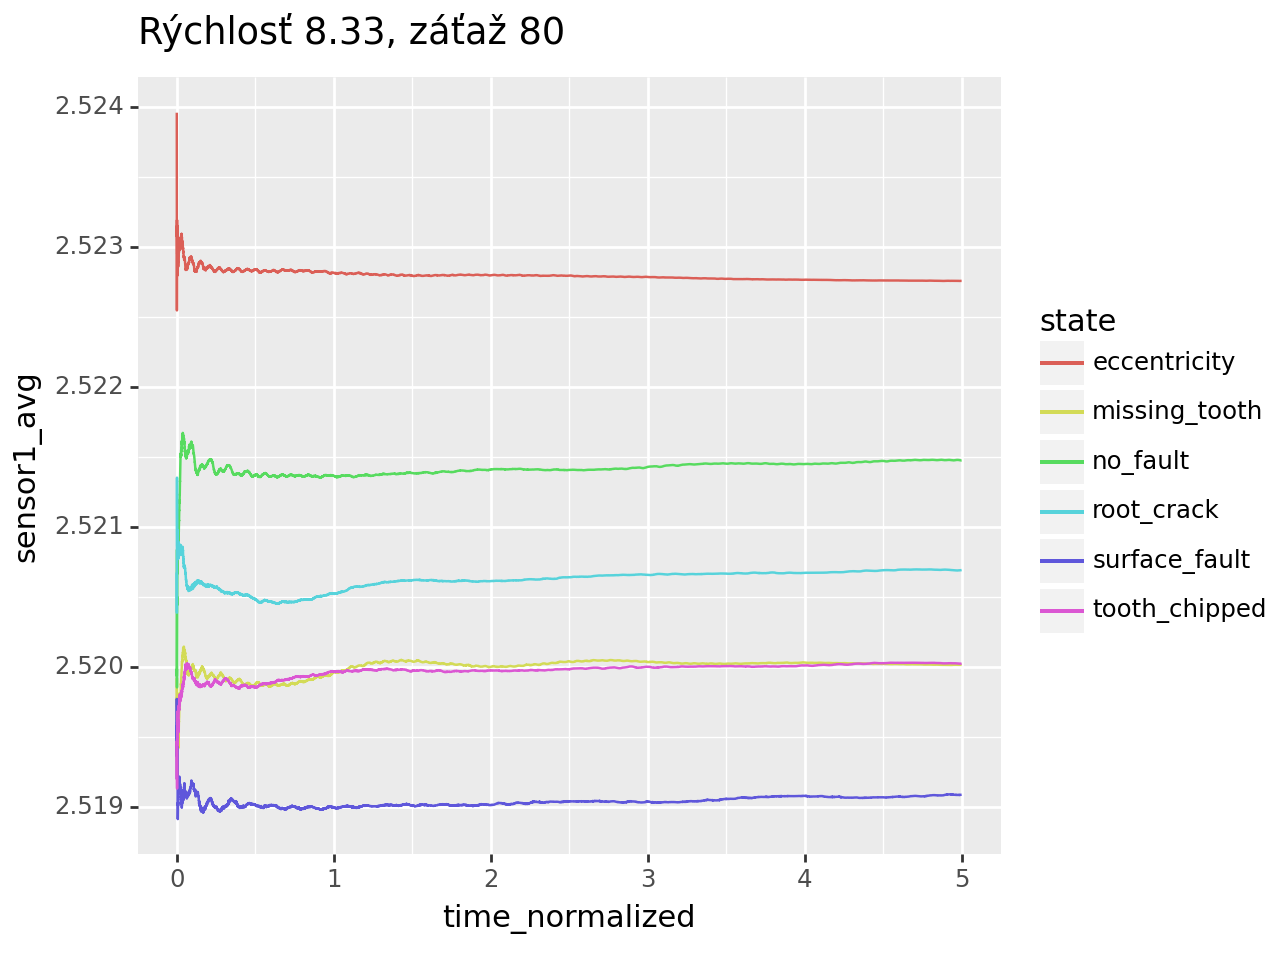

<Figure Size: (640 x 480)>

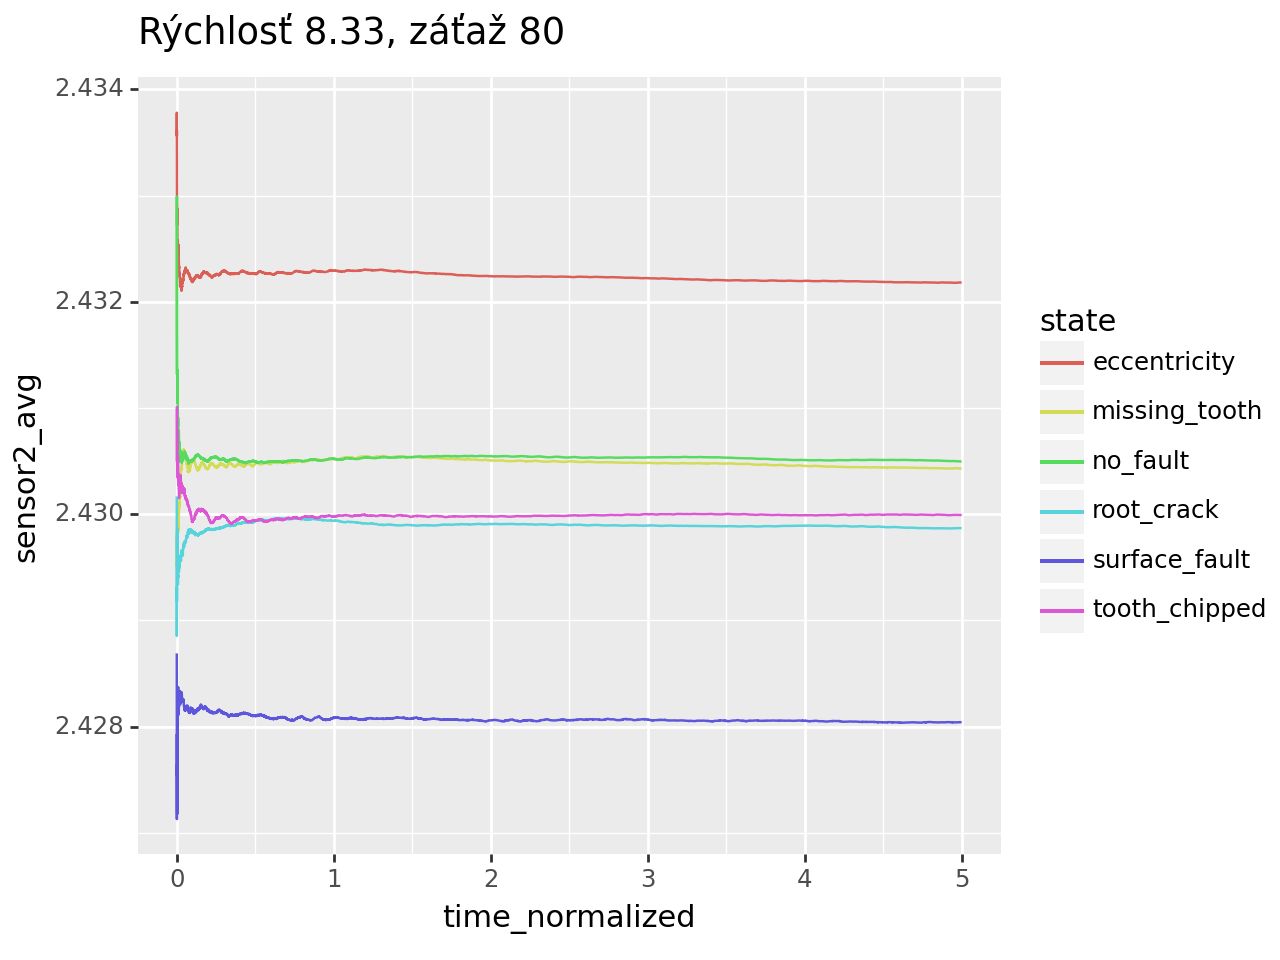

<Figure Size: (640 x 480)>

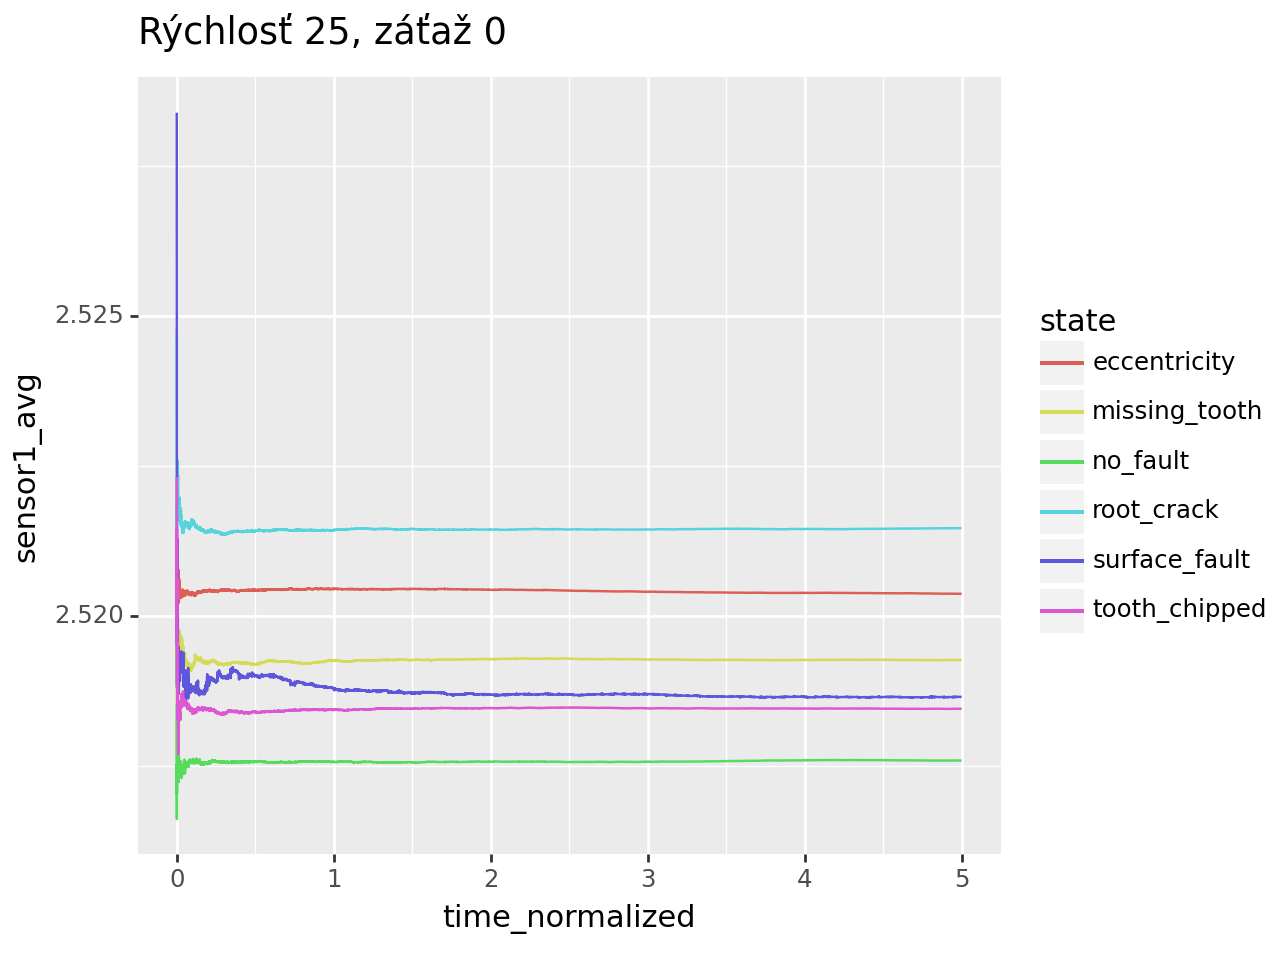

<Figure Size: (640 x 480)>

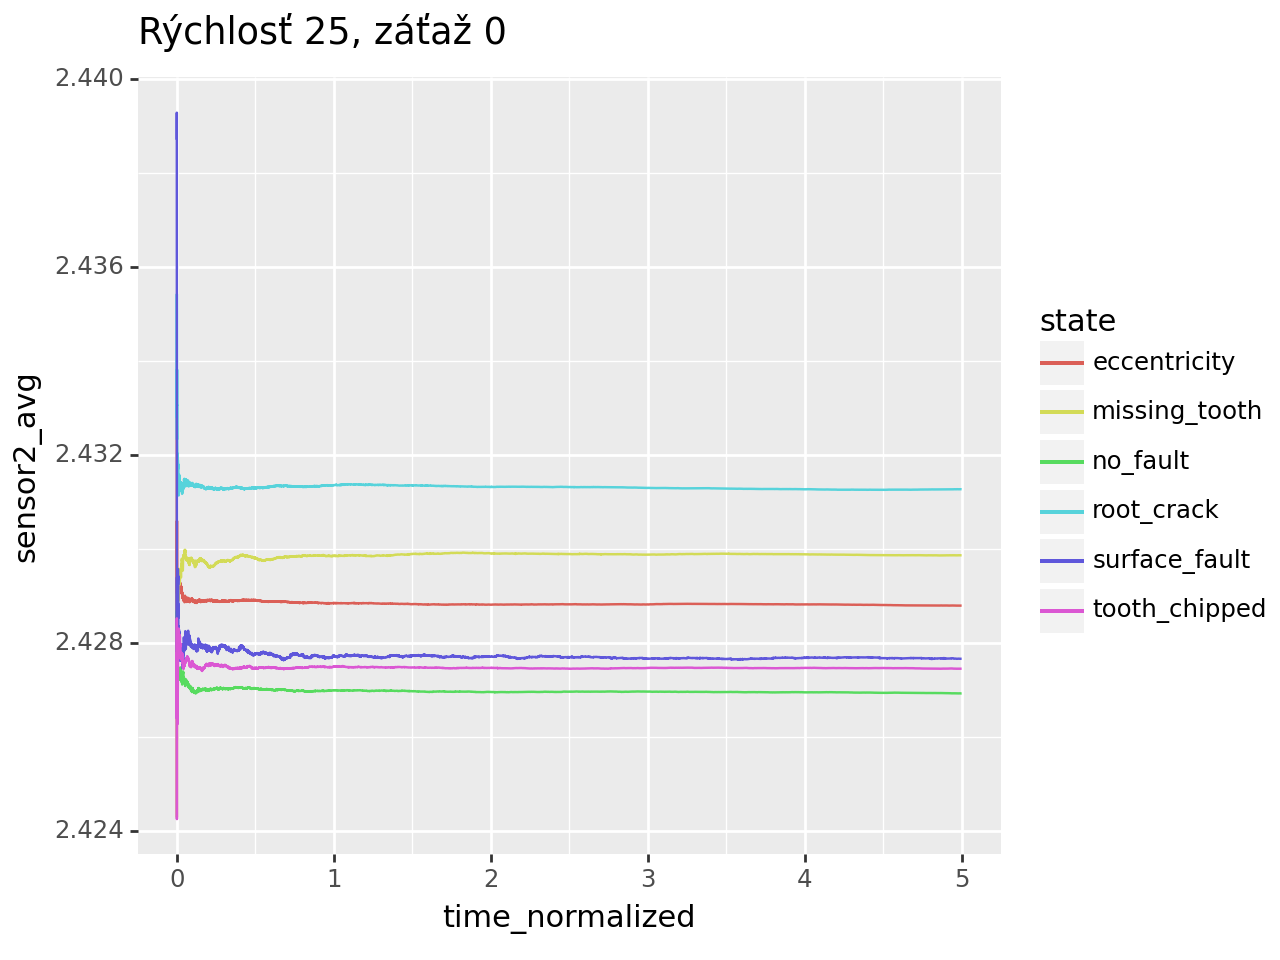

<Figure Size: (640 x 480)>

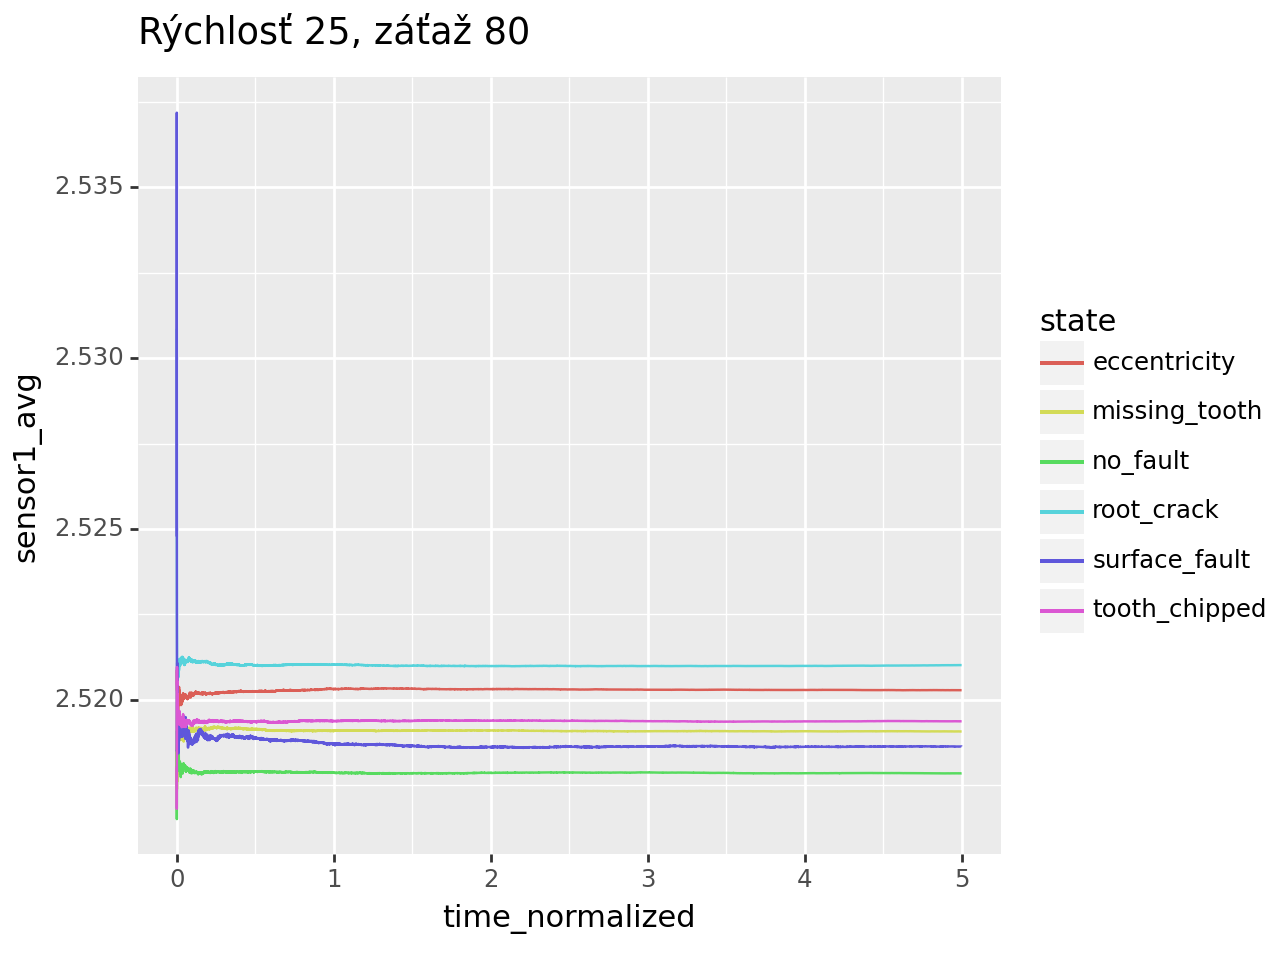

<Figure Size: (640 x 480)>

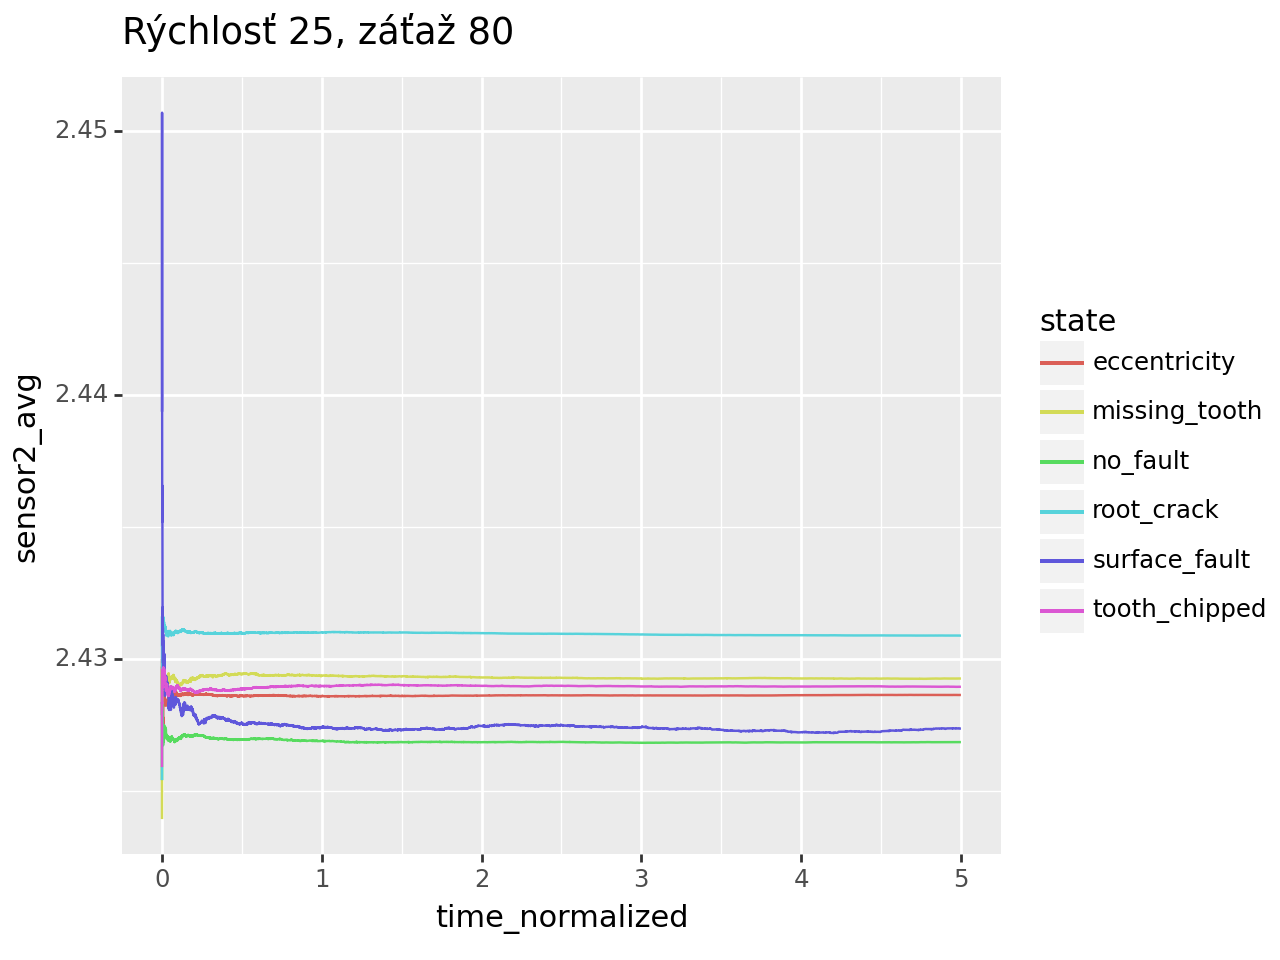

<Figure Size: (640 x 480)>

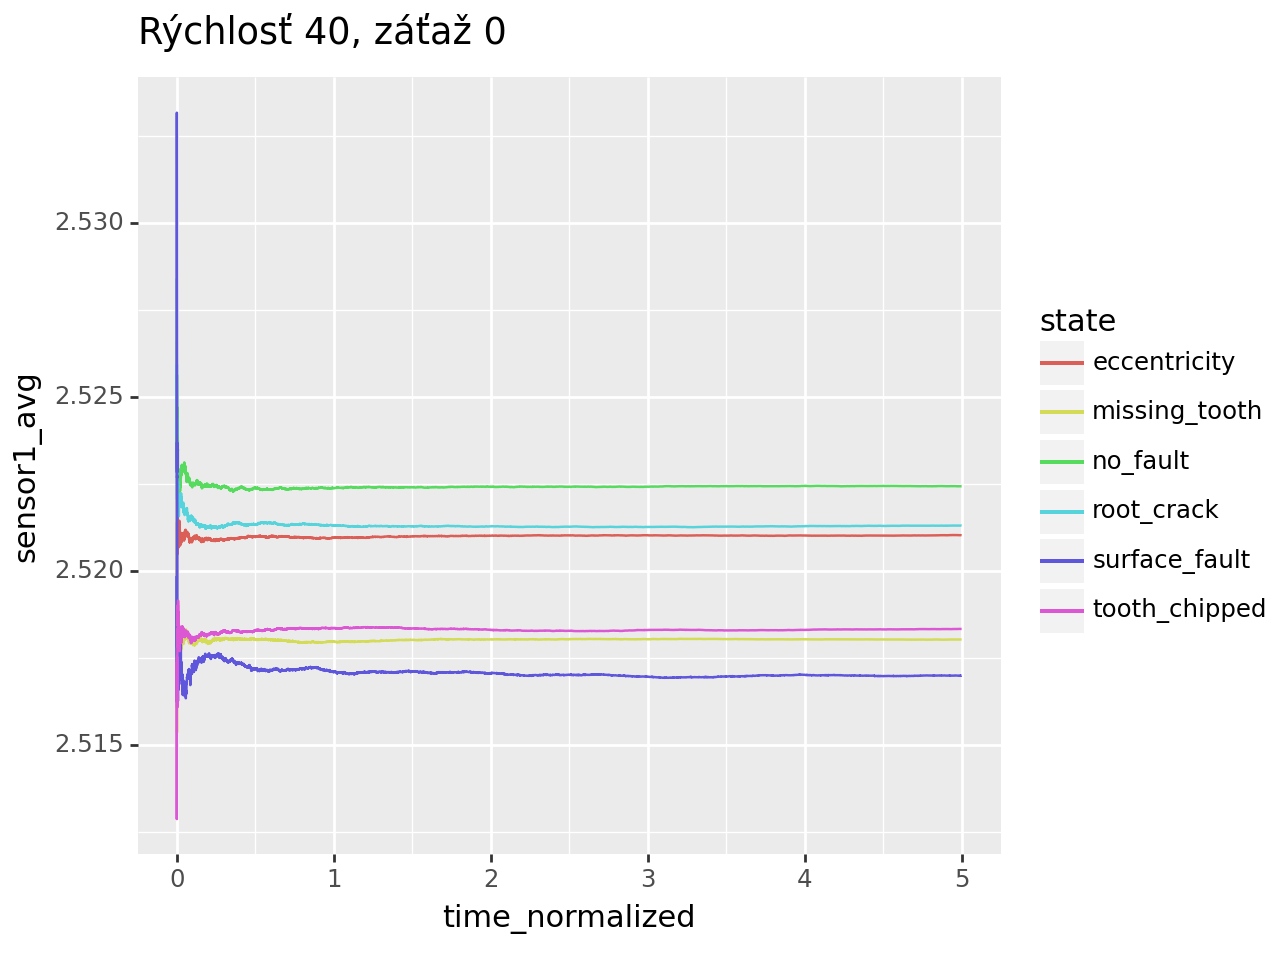

<Figure Size: (640 x 480)>

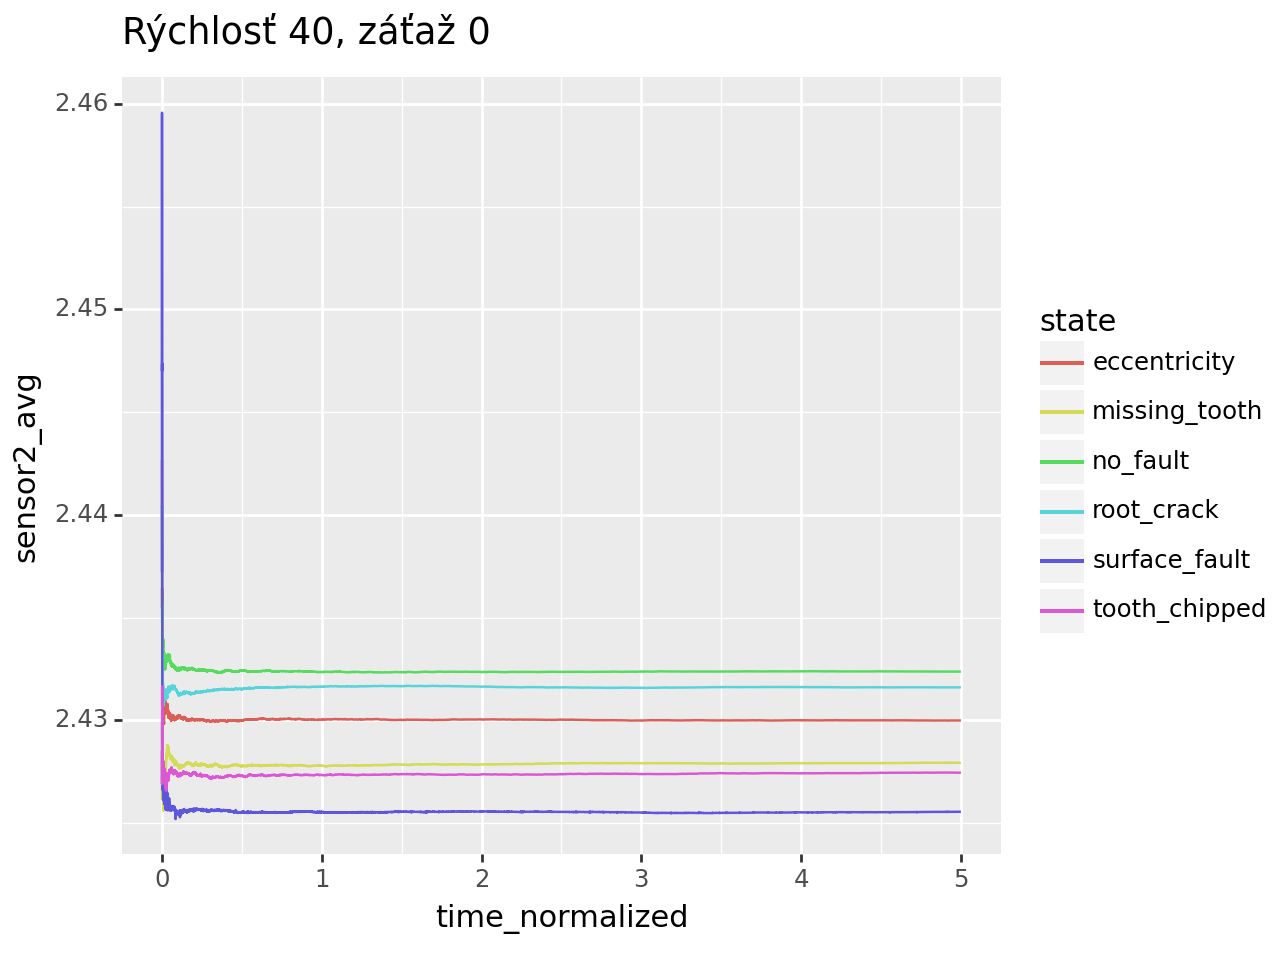

<Figure Size: (640 x 480)>

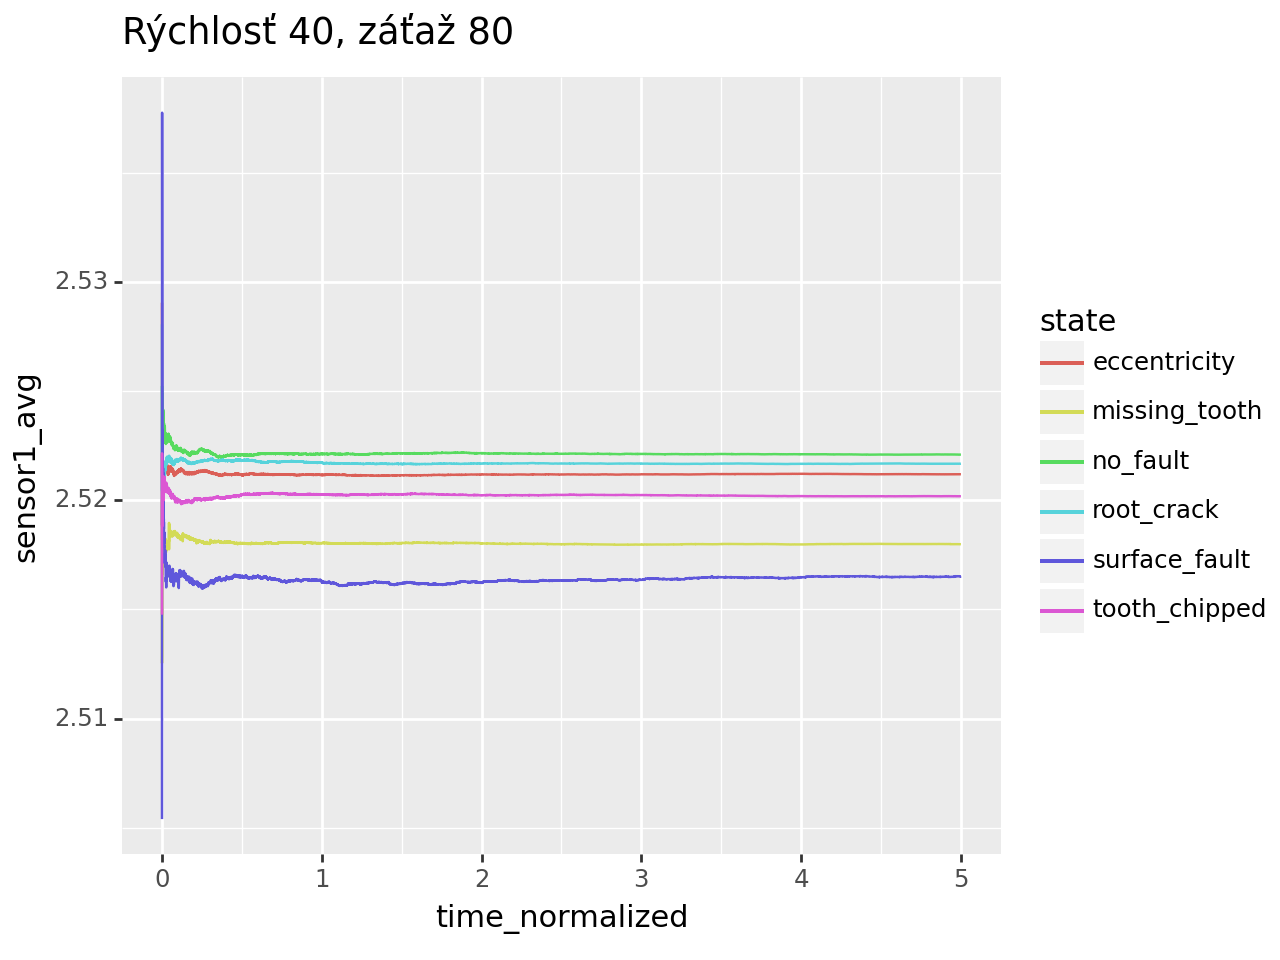

<Figure Size: (640 x 480)>

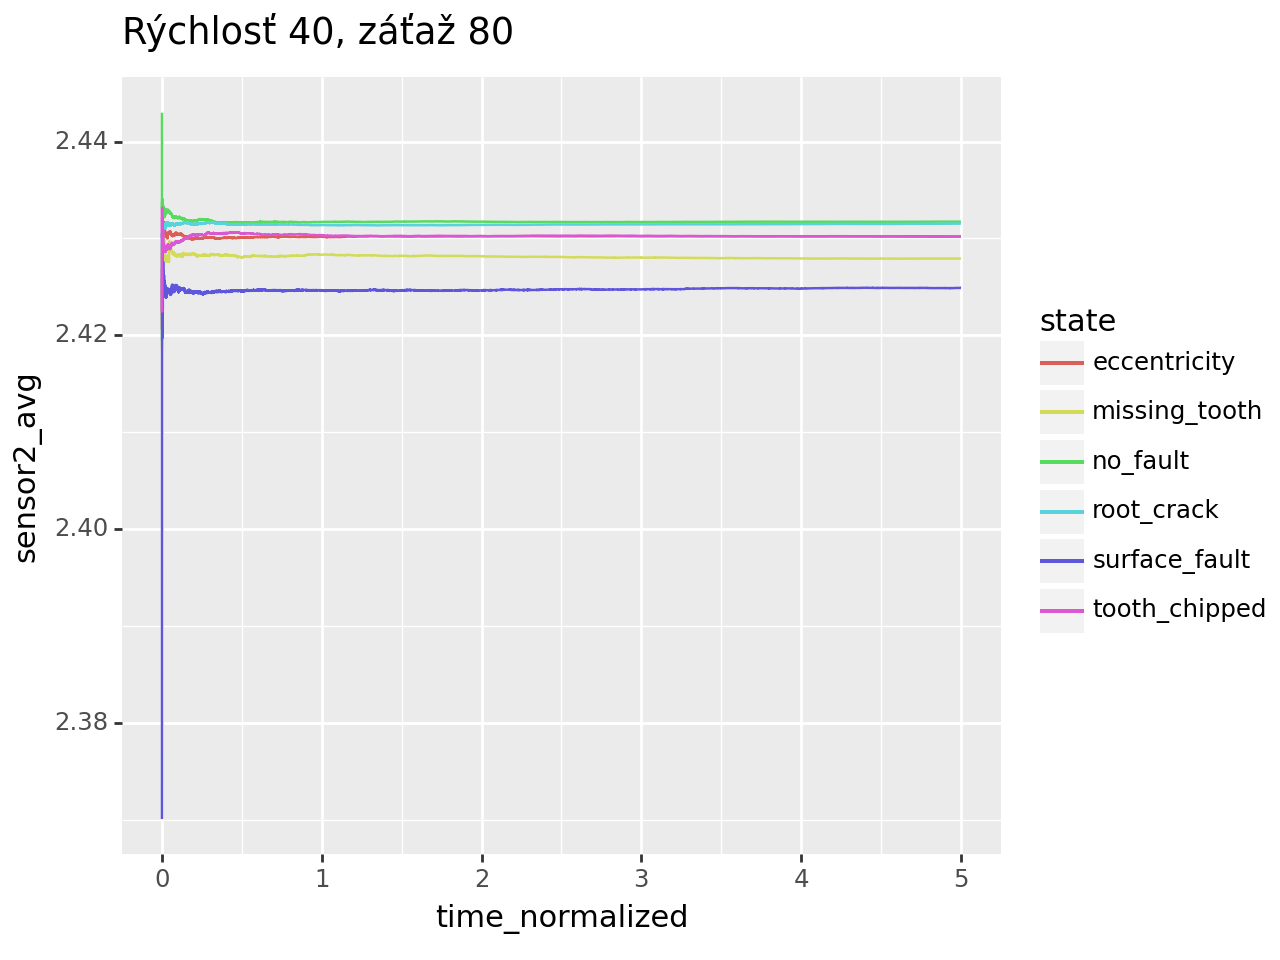

<Figure Size: (640 x 480)>

In [14]:
# Define your custom color palette
colors = ['#E41A1C', '#377EB8', '#4DAF4A', '#984EA3', '#FF7F00', '#FFFF33']

# Plot the sensor1_avg values then sensor2_avg values in time for every speedSet and load_value combination in seperate plots for each state
display(ggplot(data = speedload_8_0, mapping = aes(x = 'time_normalized', y = 'sensor1_avg', color = 'state')) + geom_line() + ggtitle('Rýchlosť 8.33, záťaž 0'))
display(ggplot(data = speedload_8_0, mapping = aes(x = 'time_normalized', y = 'sensor2_avg', color = 'state')) + geom_line() + ggtitle('Rýchlosť 8.33, záťaž 0'))
display(ggplot(data = speedload_8_80, mapping = aes(x = 'time_normalized', y = 'sensor1_avg', color = 'state')) + geom_line() + ggtitle('Rýchlosť 8.33, záťaž 80'))
display(ggplot(data = speedload_8_80, mapping = aes(x = 'time_normalized', y = 'sensor2_avg', color = 'state')) + geom_line() + ggtitle('Rýchlosť 8.33, záťaž 80'))
display(ggplot(data = speedload_25_0, mapping = aes(x = 'time_normalized', y = 'sensor1_avg', color = 'state')) + geom_line() + ggtitle('Rýchlosť 25, záťaž 0'))
display(ggplot(data = speedload_25_0, mapping = aes(x = 'time_normalized', y = 'sensor2_avg', color = 'state')) + geom_line() + ggtitle('Rýchlosť 25, záťaž 0'))
display(ggplot(data = speedload_25_80, mapping = aes(x = 'time_normalized', y = 'sensor1_avg', color = 'state')) + geom_line() + ggtitle('Rýchlosť 25, záťaž 80'))
display(ggplot(data = speedload_25_80, mapping = aes(x = 'time_normalized', y = 'sensor2_avg', color = 'state')) + geom_line() + ggtitle('Rýchlosť 25, záťaž 80'))
display(ggplot(data = speedload_40_0, mapping = aes(x = 'time_normalized', y = 'sensor1_avg', color = 'state')) + geom_line() + ggtitle('Rýchlosť 40, záťaž 0'))
display(ggplot(data = speedload_40_0, mapping = aes(x = 'time_normalized', y = 'sensor2_avg', color = 'state')) + geom_line() + ggtitle('Rýchlosť 40, záťaž 0'))
display(ggplot(data = speedload_40_80, mapping = aes(x = 'time_normalized', y = 'sensor1_avg', color = 'state')) + geom_line() + ggtitle('Rýchlosť 40, záťaž 80'))
display(ggplot(data = speedload_40_80, mapping = aes(x = 'time_normalized', y = 'sensor2_avg', color = 'state')) + geom_line() + ggtitle('Rýchlosť 40, záťaž 80'))



In [15]:
"""
display(ggplot(data=speedload_8_0, mapping=aes(x='sensor2', fill='state')) + geom_density(alpha=0.3) + stat_ecdf() + 
        scale_fill_manual(values=colors) + ggtitle('Rýchlosť 8.33, záťaž 0') + xlim(2.417, 2.44))
display(ggplot(data=speedload_8_80, mapping=aes(x='sensor2', fill='state')) + geom_density(alpha=0.3) + stat_ecdf() +
        scale_fill_manual(values=colors) + ggtitle('Rýchlosť 8.33, záťaž 80') + xlim(2.417, 2.44))
display(ggplot(data=speedload_25_0, mapping=aes(x='sensor2', fill='state')) + geom_density(alpha=0.3) + stat_ecdf() +
        scale_fill_manual(values=colors) + ggtitle('Rýchlosť 25, záťaž 0') + xlim(2.4, 2.45))
display(ggplot(data=speedload_25_80, mapping=aes(x='sensor2', fill='state')) + geom_density(alpha=0.3) + stat_ecdf() +
        scale_fill_manual(values=colors) + ggtitle('Rýchlosť 25, záťaž 80') + xlim(2.4, 2.45))
display(ggplot(data=speedload_40_0, mapping=aes(x='sensor2', fill='state')) + geom_density(alpha=0.3) + stat_ecdf() +
        scale_fill_manual(values=colors) + ggtitle('Rýchlosť 40, záťaž 0') + xlim(2.4, 2.45))
display(ggplot(data=speedload_40_80, mapping=aes(x='sensor2', fill='state')) + geom_density(alpha=0.3) + stat_ecdf() +
        scale_fill_manual(values=colors) + ggtitle('Rýchlosť 40, záťaž 80') + xlim(2.37, 2.55))

display(ggplot(data = speedload_8_80, mapping = aes(x = 'sensor2', fill = 'state')) + geom_density(alpha = 0.3)+ stat_ecdf() +
        scale_fill_manual(values=colors) + ggtitle('Rýchlosť 8.33, záťaž 80'))
display(ggplot(data = speedload_25_0, mapping = aes(x = 'sensor2', fill = 'state')) + geom_density(alpha = 0.3)+ stat_ecdf() +
        scale_fill_manual(values=colors) + ggtitle('Rýchlosť 25, záťaž 0'))
display(ggplot(data = speedload_25_80, mapping = aes(x = 'sensor2', fill = 'state')) + geom_density(alpha = 0.3)+ stat_ecdf() +
        scale_fill_manual(values=colors) + ggtitle('Rýchlosť 25, záťaž 80'))
display(ggplot(data = speedload_40_0, mapping = aes(x = 'sensor2', fill = 'state')) + geom_density(alpha = 0.3)+ stat_ecdf() +
        scale_fill_manual(values=colors) + ggtitle('Rýchlosť 40, záťaž 0'))
display(ggplot(data = speedload_40_80, mapping = aes(x = 'sensor2', fill = 'state')) + geom_density(alpha = 0.3)+ stat_ecdf() +
        scale_fill_manual(values=colors) + ggtitle('Rýchlosť 40, záťaž 80'))
"""

"\ndisplay(ggplot(data=speedload_8_0, mapping=aes(x='sensor2', fill='state')) + geom_density(alpha=0.3) + stat_ecdf() + \n        scale_fill_manual(values=colors) + ggtitle('Rýchlosť 8.33, záťaž 0') + xlim(2.417, 2.44))\ndisplay(ggplot(data=speedload_8_80, mapping=aes(x='sensor2', fill='state')) + geom_density(alpha=0.3) + stat_ecdf() +\n        scale_fill_manual(values=colors) + ggtitle('Rýchlosť 8.33, záťaž 80') + xlim(2.417, 2.44))\ndisplay(ggplot(data=speedload_25_0, mapping=aes(x='sensor2', fill='state')) + geom_density(alpha=0.3) + stat_ecdf() +\n        scale_fill_manual(values=colors) + ggtitle('Rýchlosť 25, záťaž 0') + xlim(2.4, 2.45))\ndisplay(ggplot(data=speedload_25_80, mapping=aes(x='sensor2', fill='state')) + geom_density(alpha=0.3) + stat_ecdf() +\n        scale_fill_manual(values=colors) + ggtitle('Rýchlosť 25, záťaž 80') + xlim(2.4, 2.45))\ndisplay(ggplot(data=speedload_40_0, mapping=aes(x='sensor2', fill='state')) + geom_density(alpha=0.3) + stat_ecdf() +\n        sca

In [16]:
"""
display(ggplot(data = df, mapping = aes(x = 'sensor1', y = 'sensor2', color = 'no_fault'))
         + geom_point(size = 0.1, alpha = 0.5) + facet_wrap('~no_fault'))
display(ggplot(data = df, mapping = aes(x = 'sensor1_std_exp', y = 'sensor2_std_exp', color = 'no_fault'))
         + geom_point(size = 0.1, alpha = 0.5) + facet_wrap('~no_fault'))
display(ggplot(data = df, mapping = aes(x = 'sensor1_mean_exp', y = 'sensor2_mean_exp', color = 'no_fault'))
         + geom_point(size = 0.1, alpha = 0.5) + facet_wrap('~no_fault'))
"""

"\ndisplay(ggplot(data = df, mapping = aes(x = 'sensor1', y = 'sensor2', color = 'no_fault'))\n         + geom_point(size = 0.1, alpha = 0.5) + facet_wrap('~no_fault'))\ndisplay(ggplot(data = df, mapping = aes(x = 'sensor1_std_exp', y = 'sensor2_std_exp', color = 'no_fault'))\n         + geom_point(size = 0.1, alpha = 0.5) + facet_wrap('~no_fault'))\ndisplay(ggplot(data = df, mapping = aes(x = 'sensor1_mean_exp', y = 'sensor2_mean_exp', color = 'no_fault'))\n         + geom_point(size = 0.1, alpha = 0.5) + facet_wrap('~no_fault'))\n"

In [17]:
"""
# Save DataFrames to an HDF5 file
with pd.HDFStore('speedload_data.h5', mode='w') as store:
    store.put('speedload_8_0', speedload_8_0, format='table')
    store.put('speedload_8_80', speedload_8_80, format='table')
    store.put('speedload_25_0', speedload_25_0, format='table')
    store.put('speedload_25_80', speedload_25_80, format='table')
    store.put('speedload_40_0', speedload_40_0, format='table')
    store.put('speedload_40_80', speedload_40_80, format='table')
"""

"\n# Save DataFrames to an HDF5 file\nwith pd.HDFStore('speedload_data.h5', mode='w') as store:\n    store.put('speedload_8_0', speedload_8_0, format='table')\n    store.put('speedload_8_80', speedload_8_80, format='table')\n    store.put('speedload_25_0', speedload_25_0, format='table')\n    store.put('speedload_25_80', speedload_25_80, format='table')\n    store.put('speedload_40_0', speedload_40_0, format='table')\n    store.put('speedload_40_80', speedload_40_80, format='table')\n"

In [18]:
# Find NaN values and replace with 0
df.fillna(0, inplace=True)
df.isna().sum()

sensor1             0
sensor2             0
time_x              0
speedSet            0
load_value          0
gear_fault_desc     0
state               0
time_normalized     0
time_formatted      0
sensor1_max_exp     0
sensor1_min_exp     0
sensor2_max_exp     0
sensor2_min_exp     0
sensor1_mean_exp    0
sensor2_mean_exp    0
sensor1_std_exp     0
sensor2_std_exp     0
dtype: int64

In [19]:
"""
# Create the graph above only with no_fault vs other states
display(ggplot(data = df[df.state.isin(['no_fault', 'missing_tooth'])], mapping = aes(x = 'sensor2_std_exp', y = 'sensor1_std_exp')) + geom_point(aes(color = 'state')))
display(ggplot(data = df[df.state.isin(['no_fault', 'tooth_chipped'])], mapping = aes(x = 'sensor2_std_exp', y = 'sensor1_std_exp')) + geom_point(aes(color = 'state')))
display(ggplot(data = df[df.state.isin(['no_fault', 'surface_fault'])], mapping = aes(x = 'sensor2_std_exp', y = 'sensor1_std_exp')) + geom_point(aes(color = 'state')))
display(ggplot(data = df[df.state.isin(['no_fault', 'root_crack'])], mapping = aes(x = 'sensor2_std_exp', y = 'sensor1_std_exp')) + geom_point(aes(color = 'state')))
display(ggplot(data = df[df.state.isin(['no_fault', 'eccentricity'])], mapping = aes(x = 'sensor2_std_exp', y = 'sensor1_std_exp')) + geom_point(aes(color = 'state')))
"""

"\n# Create the graph above only with no_fault vs other states\ndisplay(ggplot(data = df[df.state.isin(['no_fault', 'missing_tooth'])], mapping = aes(x = 'sensor2_std_exp', y = 'sensor1_std_exp')) + geom_point(aes(color = 'state')))\ndisplay(ggplot(data = df[df.state.isin(['no_fault', 'tooth_chipped'])], mapping = aes(x = 'sensor2_std_exp', y = 'sensor1_std_exp')) + geom_point(aes(color = 'state')))\ndisplay(ggplot(data = df[df.state.isin(['no_fault', 'surface_fault'])], mapping = aes(x = 'sensor2_std_exp', y = 'sensor1_std_exp')) + geom_point(aes(color = 'state')))\ndisplay(ggplot(data = df[df.state.isin(['no_fault', 'root_crack'])], mapping = aes(x = 'sensor2_std_exp', y = 'sensor1_std_exp')) + geom_point(aes(color = 'state')))\ndisplay(ggplot(data = df[df.state.isin(['no_fault', 'eccentricity'])], mapping = aes(x = 'sensor2_std_exp', y = 'sensor1_std_exp')) + geom_point(aes(color = 'state')))\n"

In [20]:
# Create a formated column of state as Expected: [0 1 2 3 4 5] input
display(df.state.unique())
df['state_expected'] = df.state.apply(lambda x: ['missing_tooth', 'tooth_chipped', 'surface_fault', 'no_fault', 'root_crack', 'eccentricity'].index(x))
# Save the transformation keys for state_expected to later reverse the transformation
mapping_dict = df.set_index('state_expected')['state'].to_dict()
display(mapping_dict)
state_expected_keys = pd.DataFrame(list(mapping_dict.items()), columns=['state_expected', 'state'])
display(state_expected_keys)
# Create a df dataset that excludes time_x, gear_fault_desc, state, time_formatted
df_edit = df[['sensor1', 'sensor2', 'sensor1_max_exp', 'sensor1_min_exp', 'sensor1_mean_exp', 'sensor1_std_exp', 
        'sensor2_max_exp', 'sensor2_min_exp', 'sensor2_mean_exp', 'sensor2_std_exp', 'speedSet', 'load_value', 'state_expected', 'time_normalized']]
display(df.state_expected.unique())


array(['missing_tooth', 'tooth_chipped', 'surface_fault', 'no_fault',
       'root_crack', 'eccentricity'], dtype=object)

{0: 'missing_tooth',
 1: 'tooth_chipped',
 2: 'surface_fault',
 3: 'no_fault',
 4: 'root_crack',
 5: 'eccentricity'}

,state_expected,state
0,0,missing_tooth
1,1,tooth_chipped
2,2,surface_fault
3,3,no_fault
4,4,root_crack
5,5,eccentricity


array([0, 1, 2, 3, 4, 5], dtype=int64)

In [27]:
df_edit.info()

<class 'pandas.core.frame.DataFrame'>
Index: 900000 entries, 0 to 149999
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   sensor1           900000 non-null  float64
 1   sensor2           900000 non-null  float64
 2   sensor1_max_exp   900000 non-null  float64
 3   sensor1_min_exp   900000 non-null  float64
 4   sensor1_mean_exp  900000 non-null  float64
 5   sensor1_std_exp   900000 non-null  float64
 6   sensor2_max_exp   900000 non-null  float64
 7   sensor2_min_exp   900000 non-null  float64
 8   sensor2_mean_exp  900000 non-null  float64
 9   sensor2_std_exp   900000 non-null  float64
 10  speedSet          900000 non-null  float64
 11  load_value        900000 non-null  int64  
 12  state_expected    900000 non-null  int64  
 13  time_normalized   900000 non-null  float64
dtypes: float64(12), int64(2)
memory usage: 103.0 MB


In [21]:
import sqlite3
import json
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Create if not already created, the database file for appending the model name, validation scores, hyperparameters and train/test/validation distribution
conn = sqlite3.connect('model_results.db')
c = conn.cursor()
c.execute('''CREATE TABLE IF NOT EXISTS model_results
                (model_name text, validation_score real, hyperparameters text, train_test_val text)''')
conn.commit()
conn.close()

total_size = len(df_edit)
chunk_size = int(total_size * 0.0001)  # 0.01% of data
num_chunks_train = int(total_size * 0.8 / chunk_size)
num_chunks_val = int(total_size * 0.1 / chunk_size)
num_chunks_test = int(total_size * 0.1 / chunk_size)

# Shuffle the DataFrame
df_shuffled = df_edit.sample(frac=1, random_state=42).reset_index(drop=True)

# Function to stratify and split the data into chunks
def stratified_chunk_split(dfs, num_chunks):
    # List to store chunks
    chunks = []
    
    # Get stratified samples
    for _, group_data in dfs.groupby('state_expected'):
        group_chunks = np.array_split(group_data, num_chunks)
        chunks.extend(group_chunks)
        
    # Shuffle chunks to mix classes
    np.random.shuffle(chunks)
    
    return chunks

# Stratify and split into chunks
all_chunks = stratified_chunk_split(df_shuffled, num_chunks_train + num_chunks_val + num_chunks_test)

# Separate chunks into train, validation, and test sets
train_chunks = all_chunks[:num_chunks_train]
val_chunks = all_chunks[num_chunks_train:num_chunks_train + num_chunks_val]
test_chunks = all_chunks[num_chunks_train + num_chunks_val:]

# Combine chunks back into DataFrames
X_train = pd.concat(train_chunks, ignore_index=True)
X_test = pd.concat(val_chunks, ignore_index=True)
X_val = pd.concat(test_chunks, ignore_index=True)

y_train = X_train['state_expected']
y_test = X_test['state_expected']
y_val = X_val['state_expected']

X_train['sensor1_max_10'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=10, min_periods=1).max())
X_train['sensor1_max_100'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=100, min_periods=1).max())
X_train['sensor1_max_1000'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=1000, min_periods=1).max())
X_train['sensor1_min_10'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=10, min_periods=1).min())
X_train['sensor1_min_100'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=100, min_periods=1).min())
X_train['sensor1_min_1000'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=1000, min_periods=1).min())
X_train['sensor1_mean_10'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=10, min_periods=1).mean())
X_train['sensor1_mean_100'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=100, min_periods=1).mean())
X_train['sensor1_mean_1000'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=1000, min_periods=1).mean())
X_train['sensor1_std_10'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=10, min_periods=1).std())
X_train['sensor1_std_100'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=100, min_periods=1).std())
X_train['sensor1_std_1000'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=1000, min_periods=1).std())

X_train['sensor2_max_10'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=10, min_periods=1).max())
X_train['sensor2_max_100'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=100, min_periods=1).max())
X_train['sensor2_max_1000'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=1000, min_periods=1).max())
X_train['sensor2_min_10'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=10, min_periods=1).min())
X_train['sensor2_min_100'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=100, min_periods=1).min())
X_train['sensor2_min_1000'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=1000, min_periods=1).min())
X_train['sensor2_mean_10'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=10, min_periods=1).mean())
X_train['sensor2_mean_100'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=100, min_periods=1).mean())
X_train['sensor2_mean_1000'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=1000, min_periods=1).mean())
X_train['sensor2_std_10'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=10, min_periods=1).std())
X_train['sensor2_std_100'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=100, min_periods=1).std())
X_train['sensor2_std_1000'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=1000, min_periods=1).std())

X_test['sensor1_max_10'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=10, min_periods=1).max())
X_test['sensor1_max_100'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=100, min_periods=1).max())
X_test['sensor1_max_1000'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=1000, min_periods=1).max())
X_test['sensor1_min_10'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=10, min_periods=1).min())
X_test['sensor1_min_100'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=100, min_periods=1).min())
X_test['sensor1_min_1000'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=1000, min_periods=1).min())
X_test['sensor1_mean_10'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=10, min_periods=1).mean())
X_test['sensor1_mean_100'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=100, min_periods=1).mean())
X_test['sensor1_mean_1000'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=1000, min_periods=1).mean())
X_test['sensor1_std_10'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=10, min_periods=1).std())
X_test['sensor1_std_100'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=100, min_periods=1).std())
X_test['sensor1_std_1000'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=1000, min_periods=1).std())

X_test['sensor2_max_10'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=10, min_periods=1).max())
X_test['sensor2_max_100'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=100, min_periods=1).max())
X_test['sensor2_max_1000'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=1000, min_periods=1).max())
X_test['sensor2_min_10'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=10, min_periods=1).min())
X_test['sensor2_min_100'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=100, min_periods=1).min())
X_test['sensor2_min_1000'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=1000, min_periods=1).min())
X_test['sensor2_mean_10'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=10, min_periods=1).mean())
X_test['sensor2_mean_100'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=100, min_periods=1).mean())
X_test['sensor2_mean_1000'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=1000, min_periods=1).mean())
X_test['sensor2_std_10'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=10, min_periods=1).std())
X_test['sensor2_std_100'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=100, min_periods=1).std())
X_test['sensor2_std_1000'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=1000, min_periods=1).std())

X_val['sensor1_max_10'] = X_val.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=10, min_periods=1).max())
X_val['sensor1_max_100'] = X_val.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=100, min_periods=1).max())
X_val['sensor1_max_1000'] = X_val.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=1000, min_periods=1).max())
X_val['sensor1_min_10'] = X_val.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=10, min_periods=1).min())
X_val['sensor1_min_100'] = X_val.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=100, min_periods=1).min())
X_val['sensor1_min_1000'] = X_val.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=1000, min_periods=1).min())
X_val['sensor1_mean_10'] = X_val.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=10, min_periods=1).mean())
X_val['sensor1_mean_100'] = X_val.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=100, min_periods=1).mean())
X_val['sensor1_mean_1000'] = X_val.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=1000, min_periods=1).mean())
X_val['sensor1_std_10'] = X_val.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=10, min_periods=1).std())
X_val['sensor1_std_100'] = X_val.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=100, min_periods=1).std())
X_val['sensor1_std_1000'] = X_val.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=1000, min_periods=1).std())

X_val['sensor2_max_10'] = X_val.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=10, min_periods=1).max())
X_val['sensor2_max_100'] = X_val.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=100, min_periods=1).max())
X_val['sensor2_max_1000'] = X_val.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=1000, min_periods=1).max())
X_val['sensor2_min_10'] = X_val.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=10, min_periods=1).min())
X_val['sensor2_min_100'] = X_val.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=100, min_periods=1).min())
X_val['sensor2_min_1000'] = X_val.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=1000, min_periods=1).min())
X_val['sensor2_mean_10'] = X_val.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=10, min_periods=1).mean())
X_val['sensor2_mean_100'] = X_val.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=100, min_periods=1).mean())
X_val['sensor2_mean_1000'] = X_val.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=1000, min_periods=1).mean())
X_val['sensor2_std_10'] = X_val.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=10, min_periods=1).std())
X_val['sensor2_std_100'] = X_val.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=100, min_periods=1).std())
X_val['sensor2_std_1000'] = X_val.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=1000, min_periods=1).std())


# Drop column state_expected
X_train.drop(columns='state_expected', inplace=True)
X_test.drop(columns='state_expected', inplace=True)
X_val.drop(columns='state_expected', inplace=True)

# Replace NaN values with 0
X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)
X_val.fillna(0, inplace=True)
print(y_val.value_counts())

# keep not standardized data in X_train_not_scaled, X_test_not_scaled, X_val_not_scaled
X_train_not_scaled = X_train.copy()
X_test_not_scaled = X_test.copy()
X_val_not_scaled = X_val.copy()

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

log_reg = LogisticRegression(max_iter=100, multi_class='ovr', C=0.1)
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


state_expected
2    128220
0    127830
3    127515
5    127155
4    127155
1    127125
Name: count, dtype: int64


c:\Users\rober\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Accuracy: 0.7958666666666666


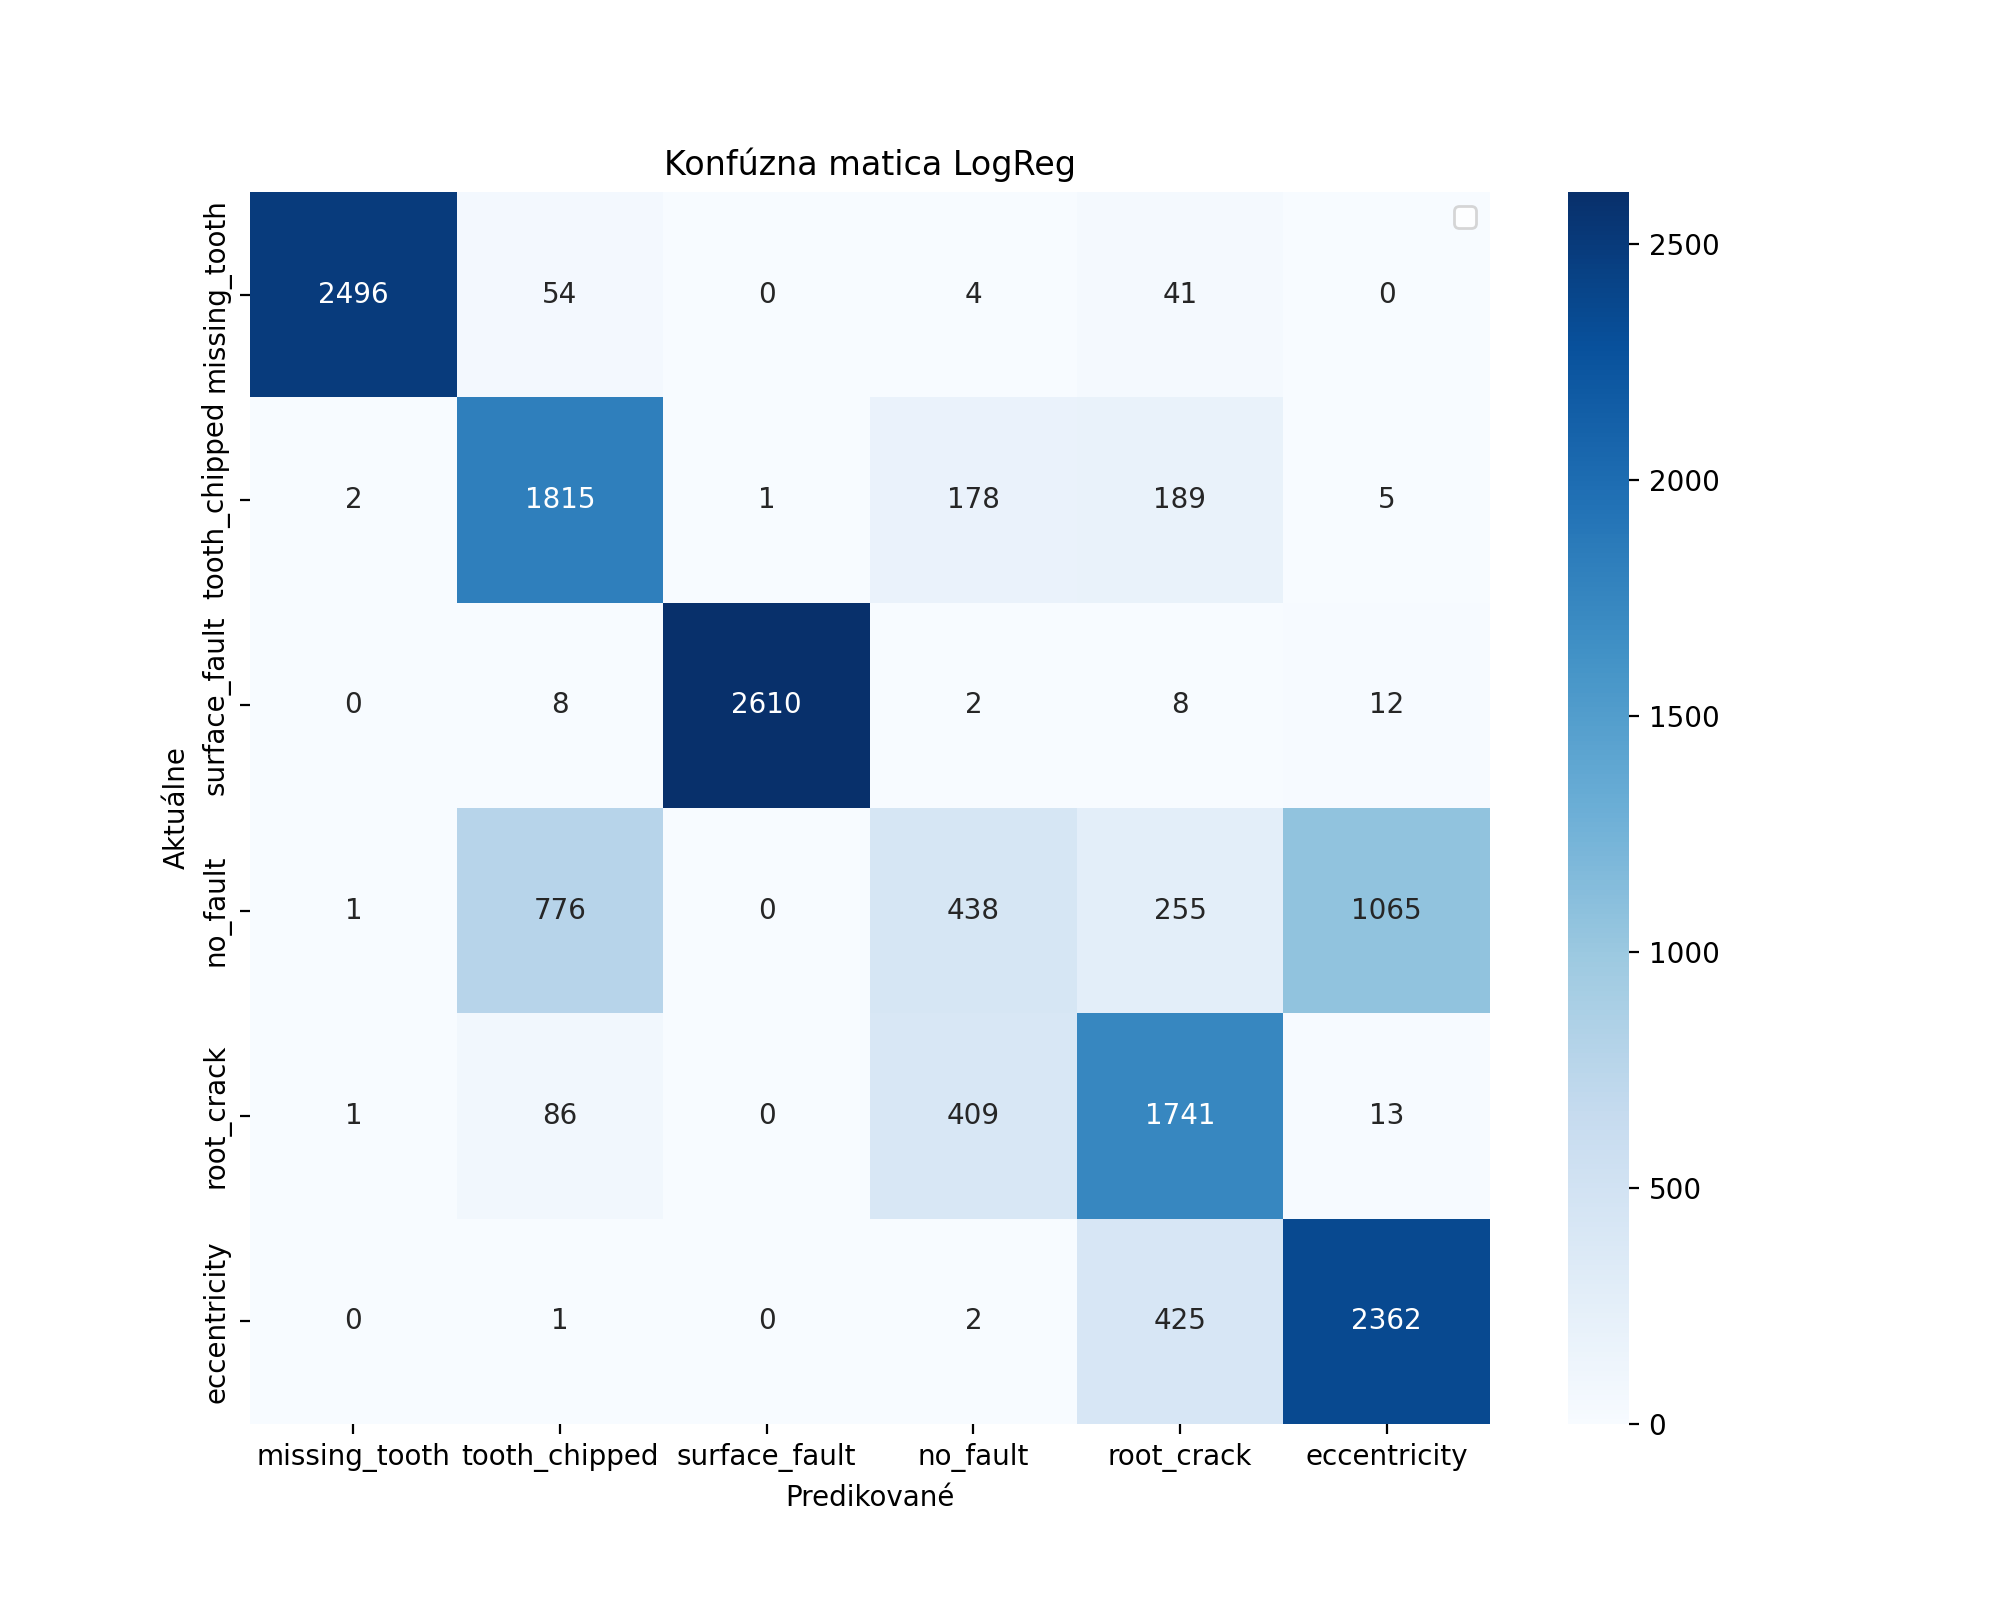

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Trasnform classes from numerical to names using state_expected_keys
log_reg.classes_ = state_expected_keys.state.values
log_reg.classes_

# Show confnusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=log_reg.classes_, yticklabels=log_reg.classes_)
plt.xlabel('Predikované')
plt.ylabel('Aktuálne')
plt.title('Konfúzna matica LogReg')
plt.legend([f'Presnosť: {accuracy:.2f}'])
plt.show()

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
import lightgbm as lgb

# Parameter grid for RandomizedSearch
param_dist_lgb = {
    'num_leaves': [31, 63, 127],
    'min_child_samples': [20, 50, 100],
    'min_child_weight': [1e-3, 1e-2, 1e-1, 1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 1e-1, 1, 2],
    'reg_lambda': [0, 1e-1, 1, 2],
}

# Setup the model
lgb_model = lgb.LGBMClassifier()
random_search_lgb = RandomizedSearchCV(lgb_model, param_distributions=param_dist_lgb, 
    n_iter=1,  
    scoring='accuracy',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1)

random_search_lgb.fit(X_train, y_train)

# Pick the best model
best_lgb_model = random_search_lgb.best_estimator_
best_lgb_model.fit(X_train, y_train)

# Predict the test set
y_pred = best_lgb_model.predict(X_test)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
display(print("Accuracy:", accuracy))

# For LightGBM example
val_pred_lgb = best_lgb_model.predict(X_val)
val_accuracy_lgb = accuracy_score(y_val, val_pred_lgb)

# Save the model name, validation score, hyperparameters and train/test/validation distribution to the database
params_str = json.dumps(random_search_lgb.best_params_)
conn = sqlite3.connect('model_results.db')
c = conn.cursor()
c.execute("INSERT INTO model_results VALUES (?, ?, ?, ?)", ('LightGBM', val_accuracy_lgb, params_str, '80/20/1'))
conn.commit()

# Print the validation accuracy
print(f'Validation Accuracy for LightGBM: {val_accuracy_lgb}')

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015569 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5572
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 25
[LightGBM] [Info] Start training from score -1.811707
[LightGBM] [Info] Start training from score -1.790510
[LightGBM] [Info] Start training from score -1.774165
[LightGBM] [Info] Start training from score -1.761715
[LightGBM] [Info] Start training from score -1.798029
[LightGBM] [Info] Start training from score -1.815540
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

None

Validation Accuracy for LightGBM: 0.9981124183006536


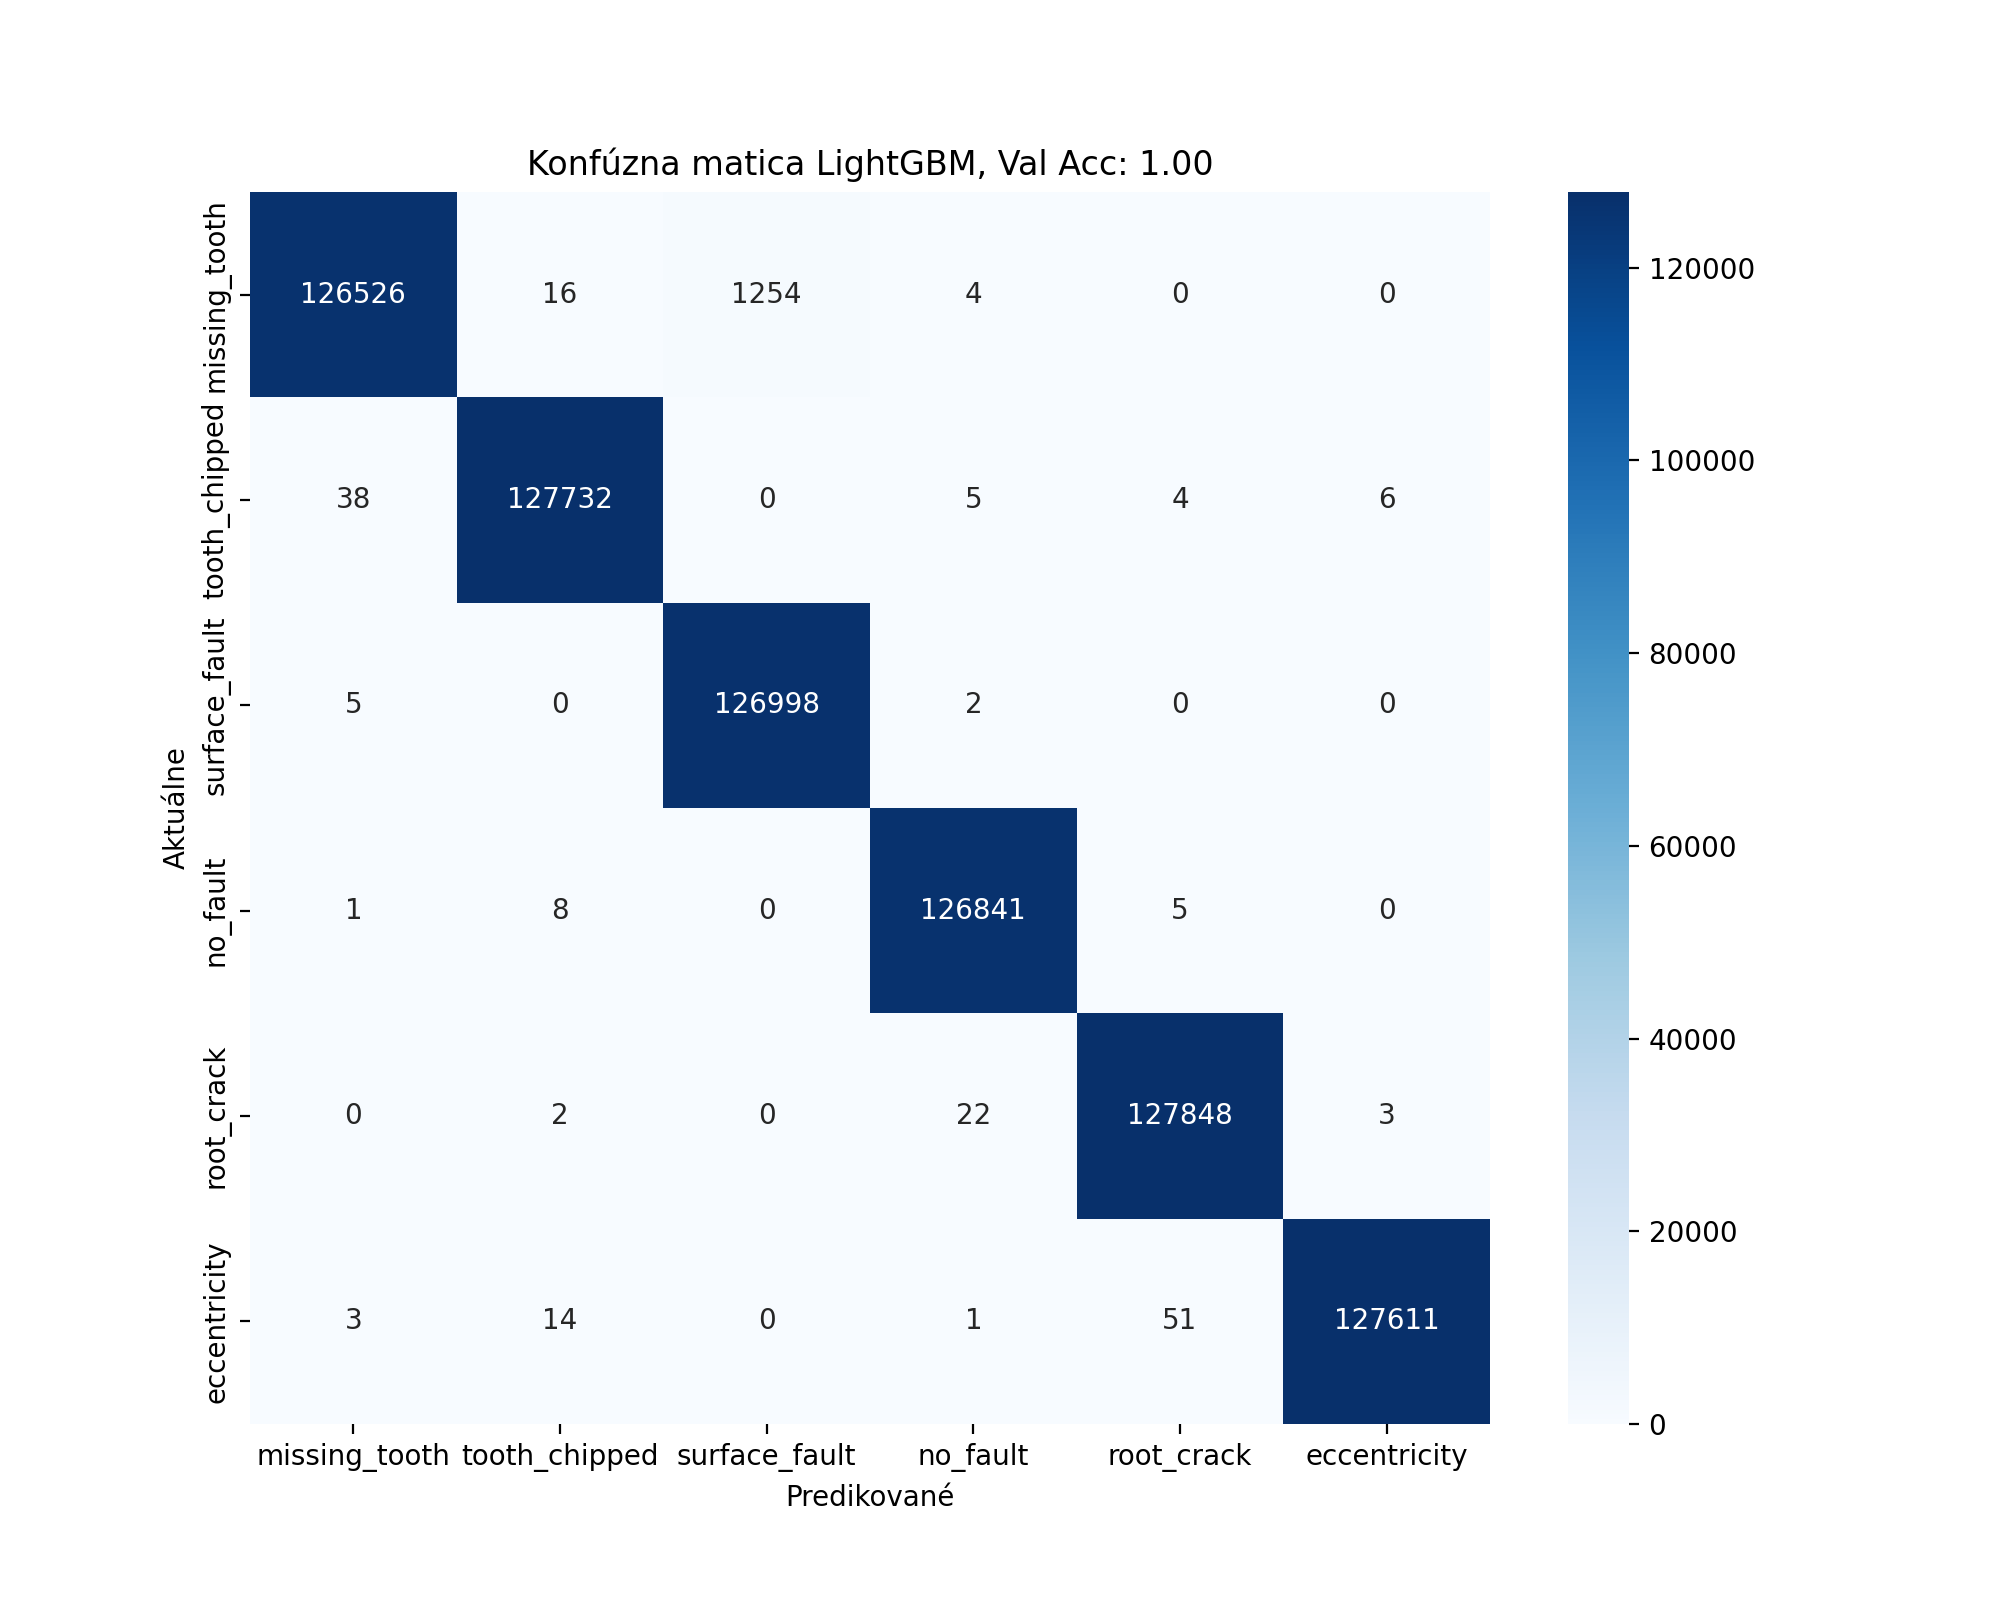

In [ ]:

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Calculate the confusion matrix
cm = confusion_matrix(y_val, val_pred_lgb)

# Trasnform classes from numerical to names in someway
predicted_names = [mapping_dict[label] for label in best_lgb_model.classes_]
# Show confnusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=predicted_names, yticklabels=predicted_names)
plt.xlabel('Predikované')
plt.ylabel('Aktuálne')
plt.title(f'Konfúzna matica LightGBM, Val Acc: {val_accuracy_lgb:.2f}')
plt.show()



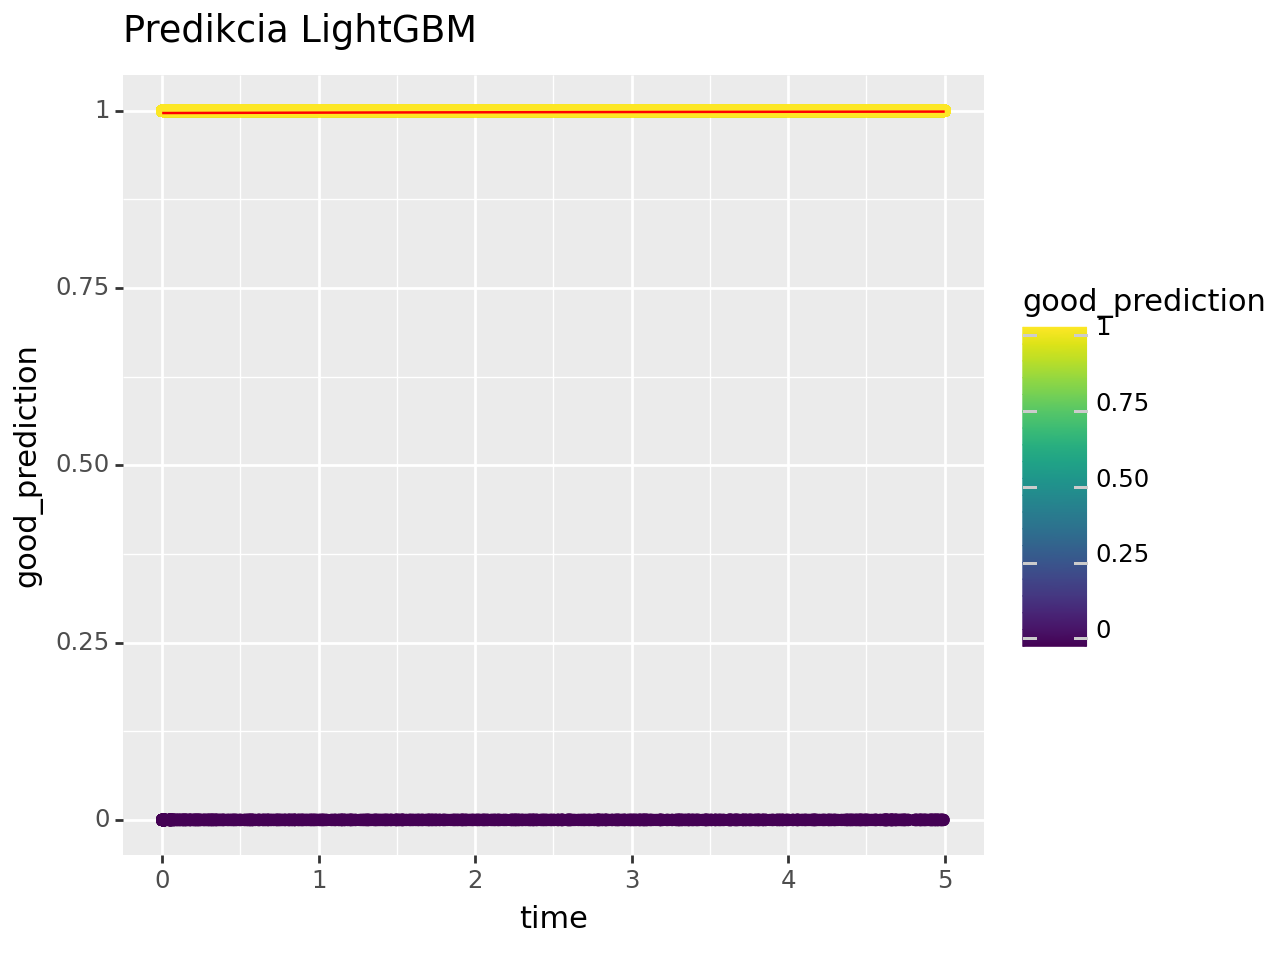

<Figure Size: (640 x 480)>

In [ ]:
dfer = y_val.reset_index(drop=True).to_frame()
dfer['time'] = X_val_not_scaled.time_normalized.reset_index(drop=True)
dfer['state'] = val_pred_lgb
dfer['yval'] = y_val.reset_index(drop=True)
dfer['range'] = dfer.index
dfer['good_prediction'] = (dfer.state == dfer.yval).astype(int)

# Assuming 'time' is your feature and 'good_prediction' is the binary outcome
X = dfer[['time']].values  # Features need to be 2D for scikit-learn
y = dfer['good_prediction'].values  # Target variable

# Fit the logistic regression model
model = LogisticRegression()
model.fit(X, y)

# Generate a range of x-values for predictions
x_range = np.linspace(dfer['time'].min(), dfer['time'].max(), 300).reshape(-1, 1)

# Predict probabilities for the generated x-values
y_pred = model.predict_proba(x_range)[:, 1]  # Get probabilities for the positive class

from plotnine import ggplot, aes, geom_point, geom_line, ggtitle

# Original data points
original_plot = (ggplot(dfer, aes(x='time', y='good_prediction', color='good_prediction')) +
                 geom_point() +
                 ggtitle('Predikcia LightGBM'))

# Create a DataFrame for the logistic curve
logistic_df = pd.DataFrame({'time': x_range.flatten(), 'probability': y_pred})

# Add the logistic curve to the plot
logistic_plot = (original_plot +
                 geom_line(data=logistic_df, mapping=aes(x='time', y='probability'), color='red'))

logistic_plot


In [ ]:
# Create XGB Classifier
param_dist_xgb = {
    'max_depth': [3, 6, 10],
    'min_child_weight': [1, 5, 10],
    'gamma': [0.5, 1, 1.5, 2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0.01, 0.1, 1],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 500],
}

# Setup the model
xgb_model = xgb.XGBClassifier()
random_search_xgb = RandomizedSearchCV(lgb_model, param_distributions=param_dist_xgb, 
    n_iter=1,  
    scoring='accuracy',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1)

random_search_xgb.fit(X_train, y_train)

# Pick the best model
best_xgb_model = random_search_xgb.best_estimator_
best_xgb_model.fit(X_train, y_train)

# Predict the test set
y_pred = best_xgb_model.predict(X_test)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
display(print("Accuracy:", accuracy))

# For LightGBM example
val_pred_xgb = best_xgb_model.predict(X_val)
val_accuracy_xgb = accuracy_score(y_val, val_pred_xgb)

# Save the model name, validation score, hyperparameters and train/test/validation distribution to the database
params_str = json.dumps(random_search_xgb.best_params_)
conn = sqlite3.connect('model_results.db')
c = conn.cursor()
c.execute("INSERT INTO model_results VALUES (?, ?, ?, ?)", ('LightGBM', val_accuracy_xgb, params_str, '80/20/1'))
conn.commit()

# Print the validation accuracy
print(f'Validation Accuracy for XGBM: {val_accuracy_xgb}')

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016027 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5572
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 25
[LightGBM] [Info] Start training from score -1.811707
[LightGBM] [Info] Start training from score -1.790510
[LightGBM] [Info] Start training from score -1.774165
[LightGBM] [Info] Start training from score -1.761715
[LightGBM] [Info] Start training from score -1.798029
[LightGBM] [Info] Start train

None

[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Validation Accuracy for XGBM: 0.9995176470588235


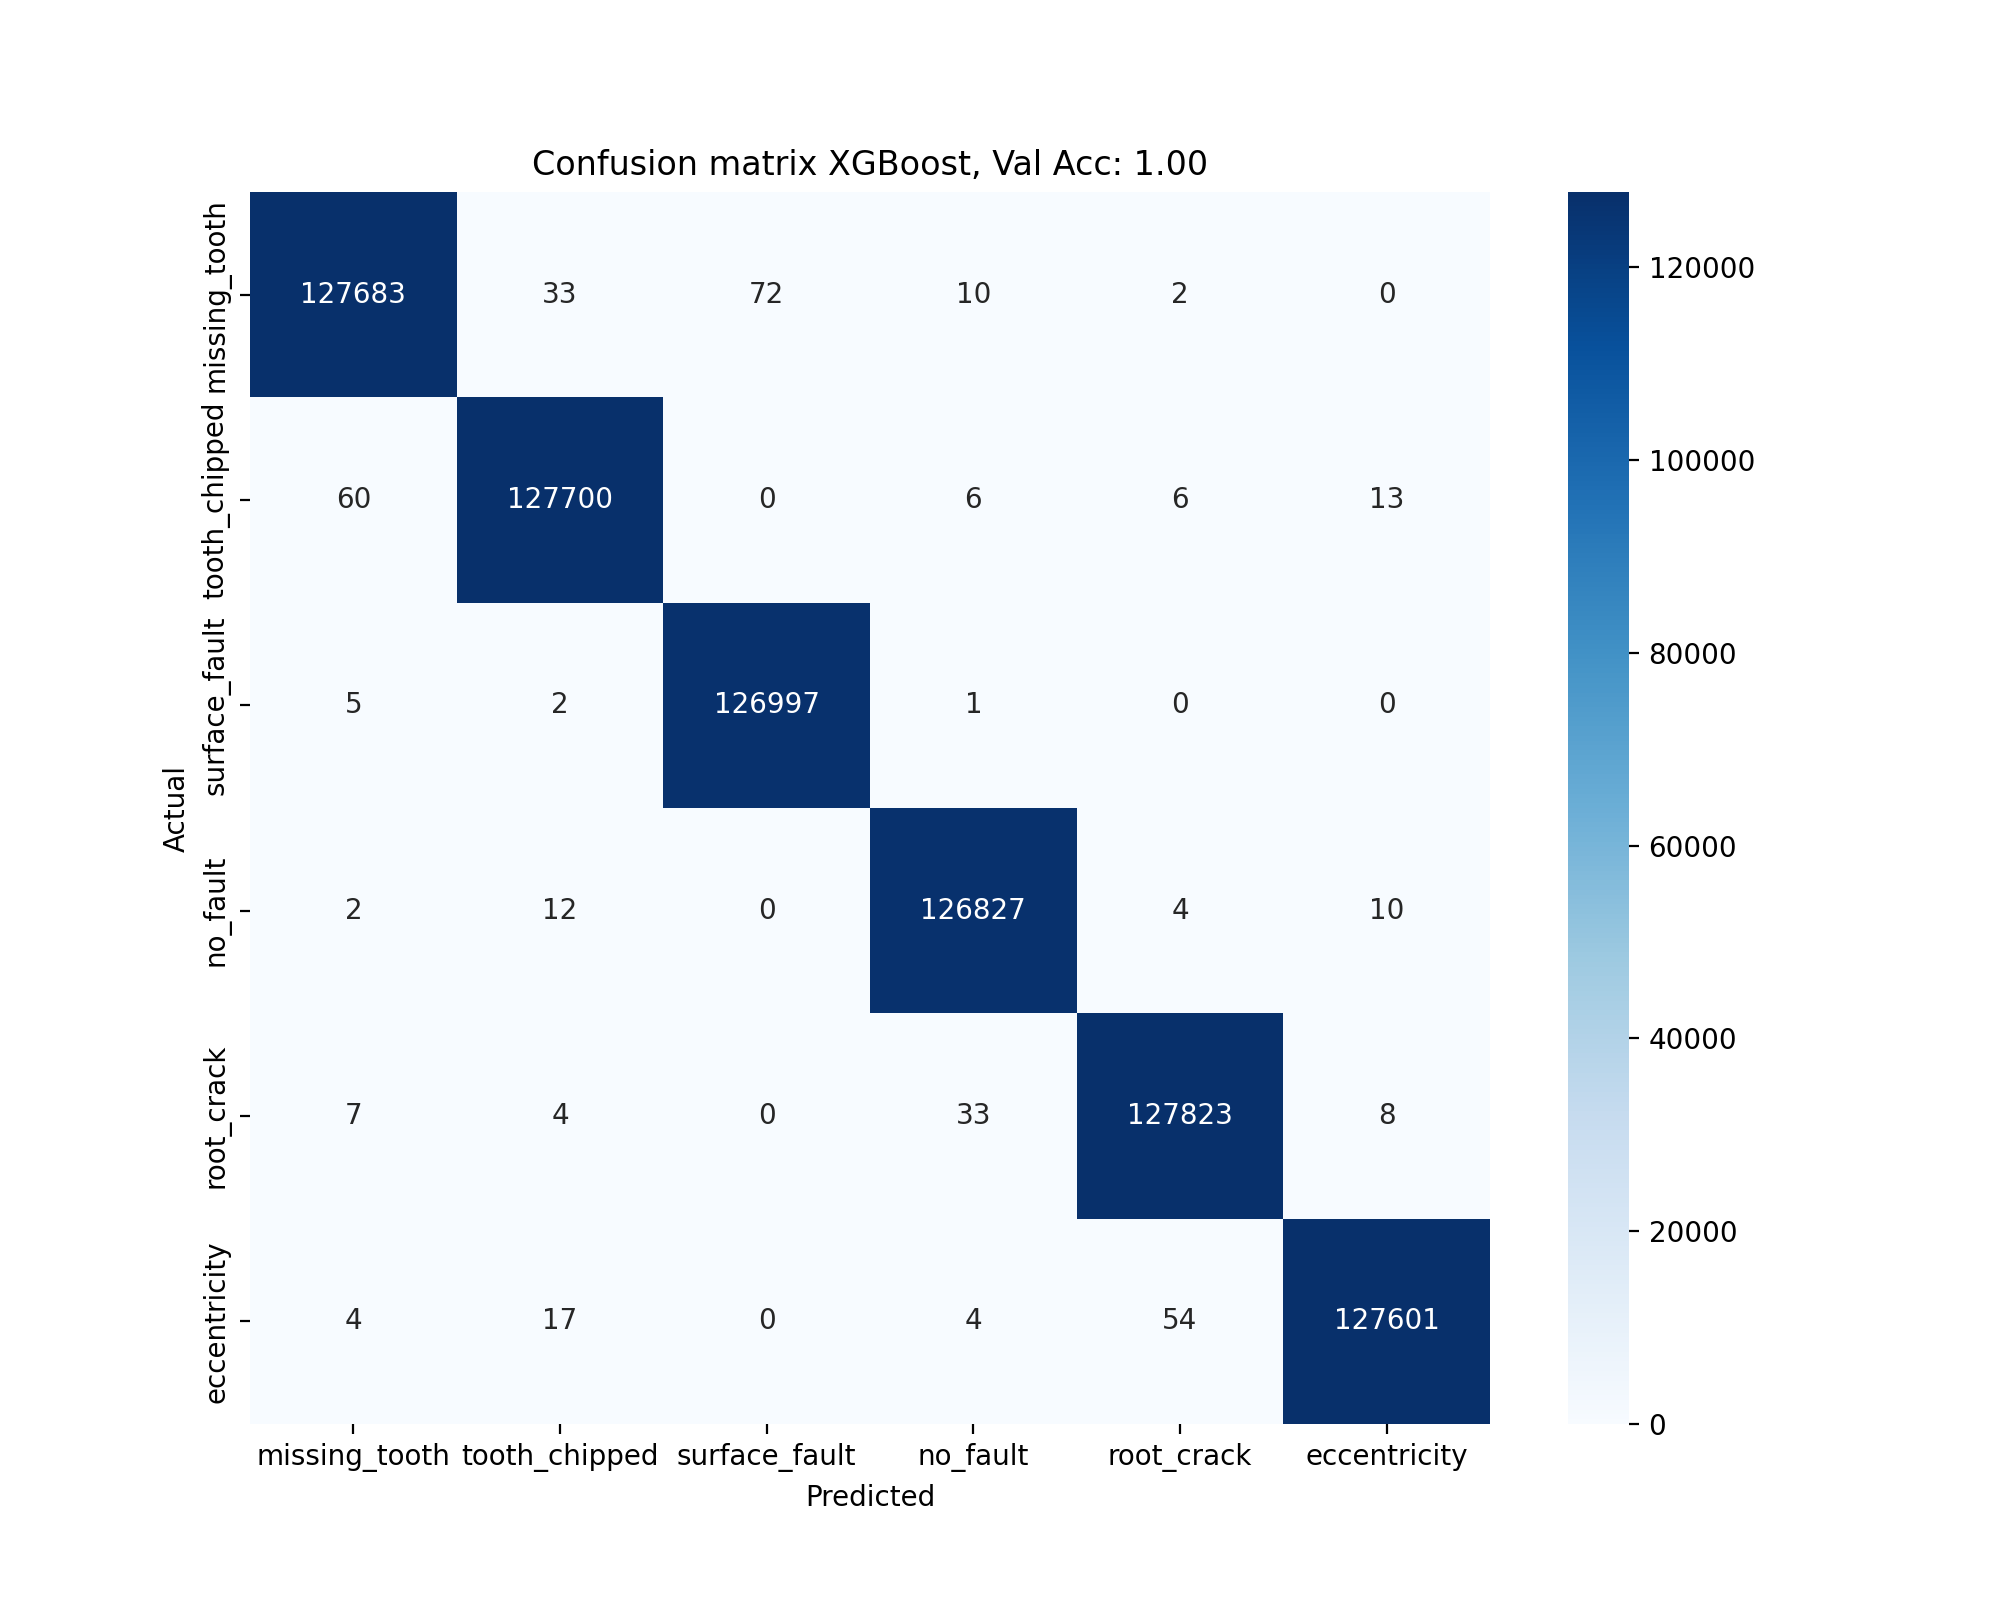

In [ ]:
# Calculate the confusion matrix
cm = confusion_matrix(y_val, val_pred_xgb)

# Trasnform classes from numerical to names using state_expected_keys
predicted_names = [mapping_dict[label] for label in best_xgb_model.classes_]

# Show confnusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=predicted_names, yticklabels=predicted_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion matrix XGBoost, Val Acc: {val_accuracy_xgb:.2f}')
plt.show()




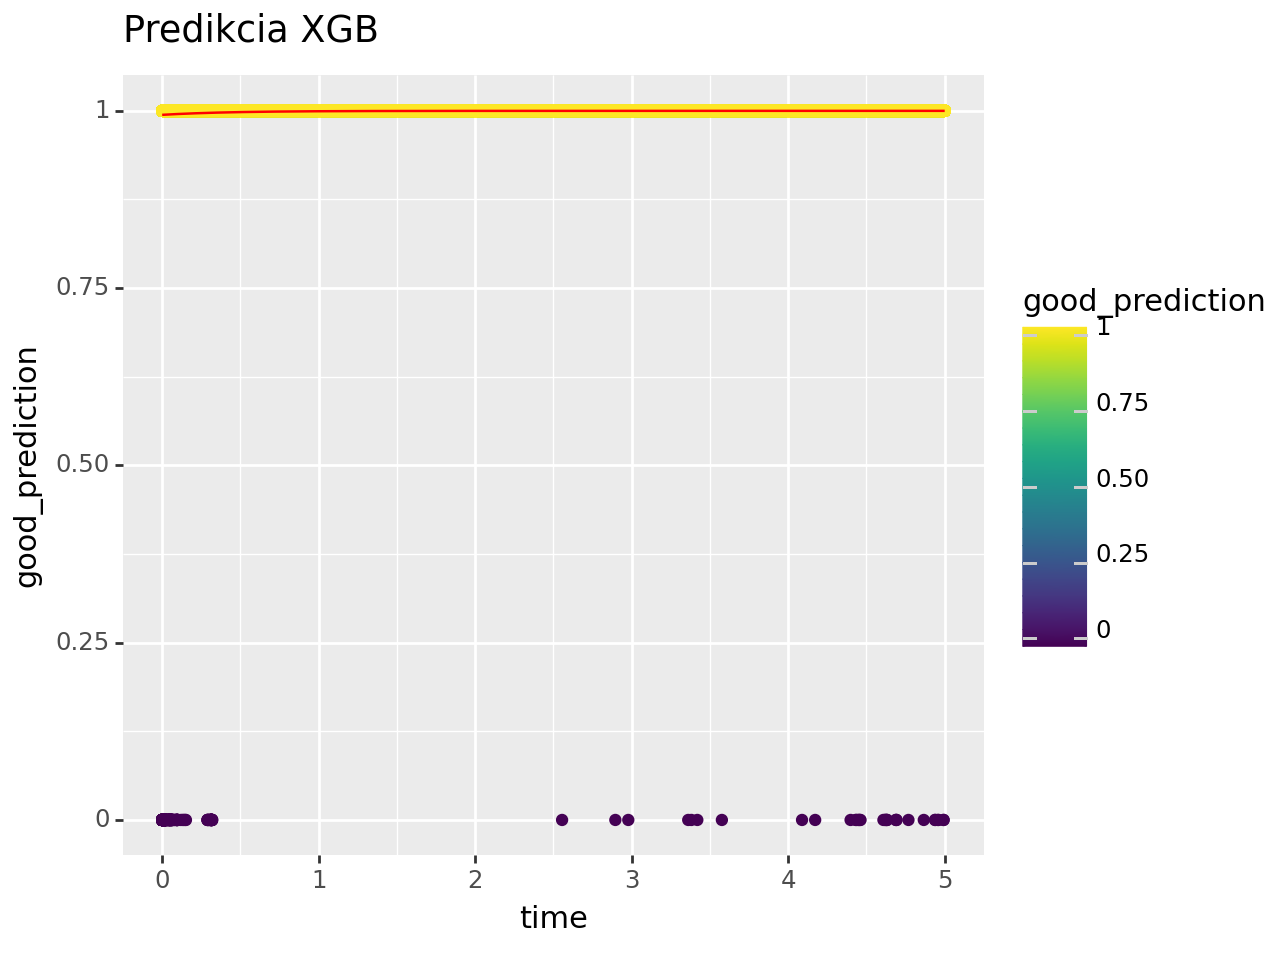

<Figure Size: (640 x 480)>

In [ ]:
dfer = y_val.reset_index(drop=True).to_frame()
dfer['time'] = X_val_not_scaled.time_normalized.reset_index(drop=True)
dfer['state'] = val_pred_xgb
dfer['yval'] = y_val.reset_index(drop=True)
dfer['range'] = dfer.index
dfer['good_prediction'] = (dfer.state == dfer.yval).astype(int)

# Assuming 'time' is your feature and 'good_prediction' is the binary outcome
X = dfer[['time']].values  # Features need to be 2D for scikit-learn
y = dfer['good_prediction'].values  # Target variable

# Fit the logistic regression model
model = LogisticRegression()
model.fit(X, y)

# Generate a range of x-values for predictions
x_range = np.linspace(dfer['time'].min(), dfer['time'].max(), 300).reshape(-1, 1)

# Predict probabilities for the generated x-values
y_pred = model.predict_proba(x_range)[:, 1]  # Get probabilities for the positive class

from plotnine import ggplot, aes, geom_point, geom_line, ggtitle

# Original data points
original_plot = (ggplot(dfer, aes(x='time', y='good_prediction', color='good_prediction')) +
                 geom_point() +
                 ggtitle('Predikcia XGB'))

# Create a DataFrame for the logistic curve
logistic_df = pd.DataFrame({'time': x_range.flatten(), 'probability': y_pred})

# Add the logistic curve to the plot
logistic_plot = (original_plot +
                 geom_line(data=logistic_df, mapping=aes(x='time', y='probability'), color='red'))

logistic_plot


In [ ]:
# Create a KNN model for classification using the df dataset print the accuracy of the model
param_distributions_knn = {
    'n_neighbors': [5, 10, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan'],
}

# Setup the model
knn_model = KNeighborsClassifier()
random_search_knn = RandomizedSearchCV(knn_model, param_distributions=param_distributions_knn, 
    n_iter=1,  
    scoring='accuracy',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1)

random_search_knn.fit(X_train, y_train)

# Pick the best model
best_knn_model = random_search_knn.best_estimator_
best_knn_model.fit(X_train, y_train)

# Predict the test set
y_pred = best_knn_model.predict(X_test)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
display(print("Accuracy:", accuracy))

# For LightGBM example
val_pred_knn = best_knn_model.predict(X_val)
val_accuracy_knn = accuracy_score(y_val, val_pred_knn)

# Save the model name, validation score, hyperparameters and train/test/validation distribution to the database
conn = sqlite3.connect('model_results.db')
params_str = json.dumps(random_search_knn.best_params_)
c = conn.cursor()
c.execute("INSERT INTO model_results VALUES (?, ?, ?, ?)", ('KNN', val_accuracy_knn, params_str, '80/20/1'))
conn.commit()

# Print the validation accuracy
print(f'Validation Accuracy for KNN: {val_accuracy_knn}')


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Accuracy: 0.9939333333333333


None

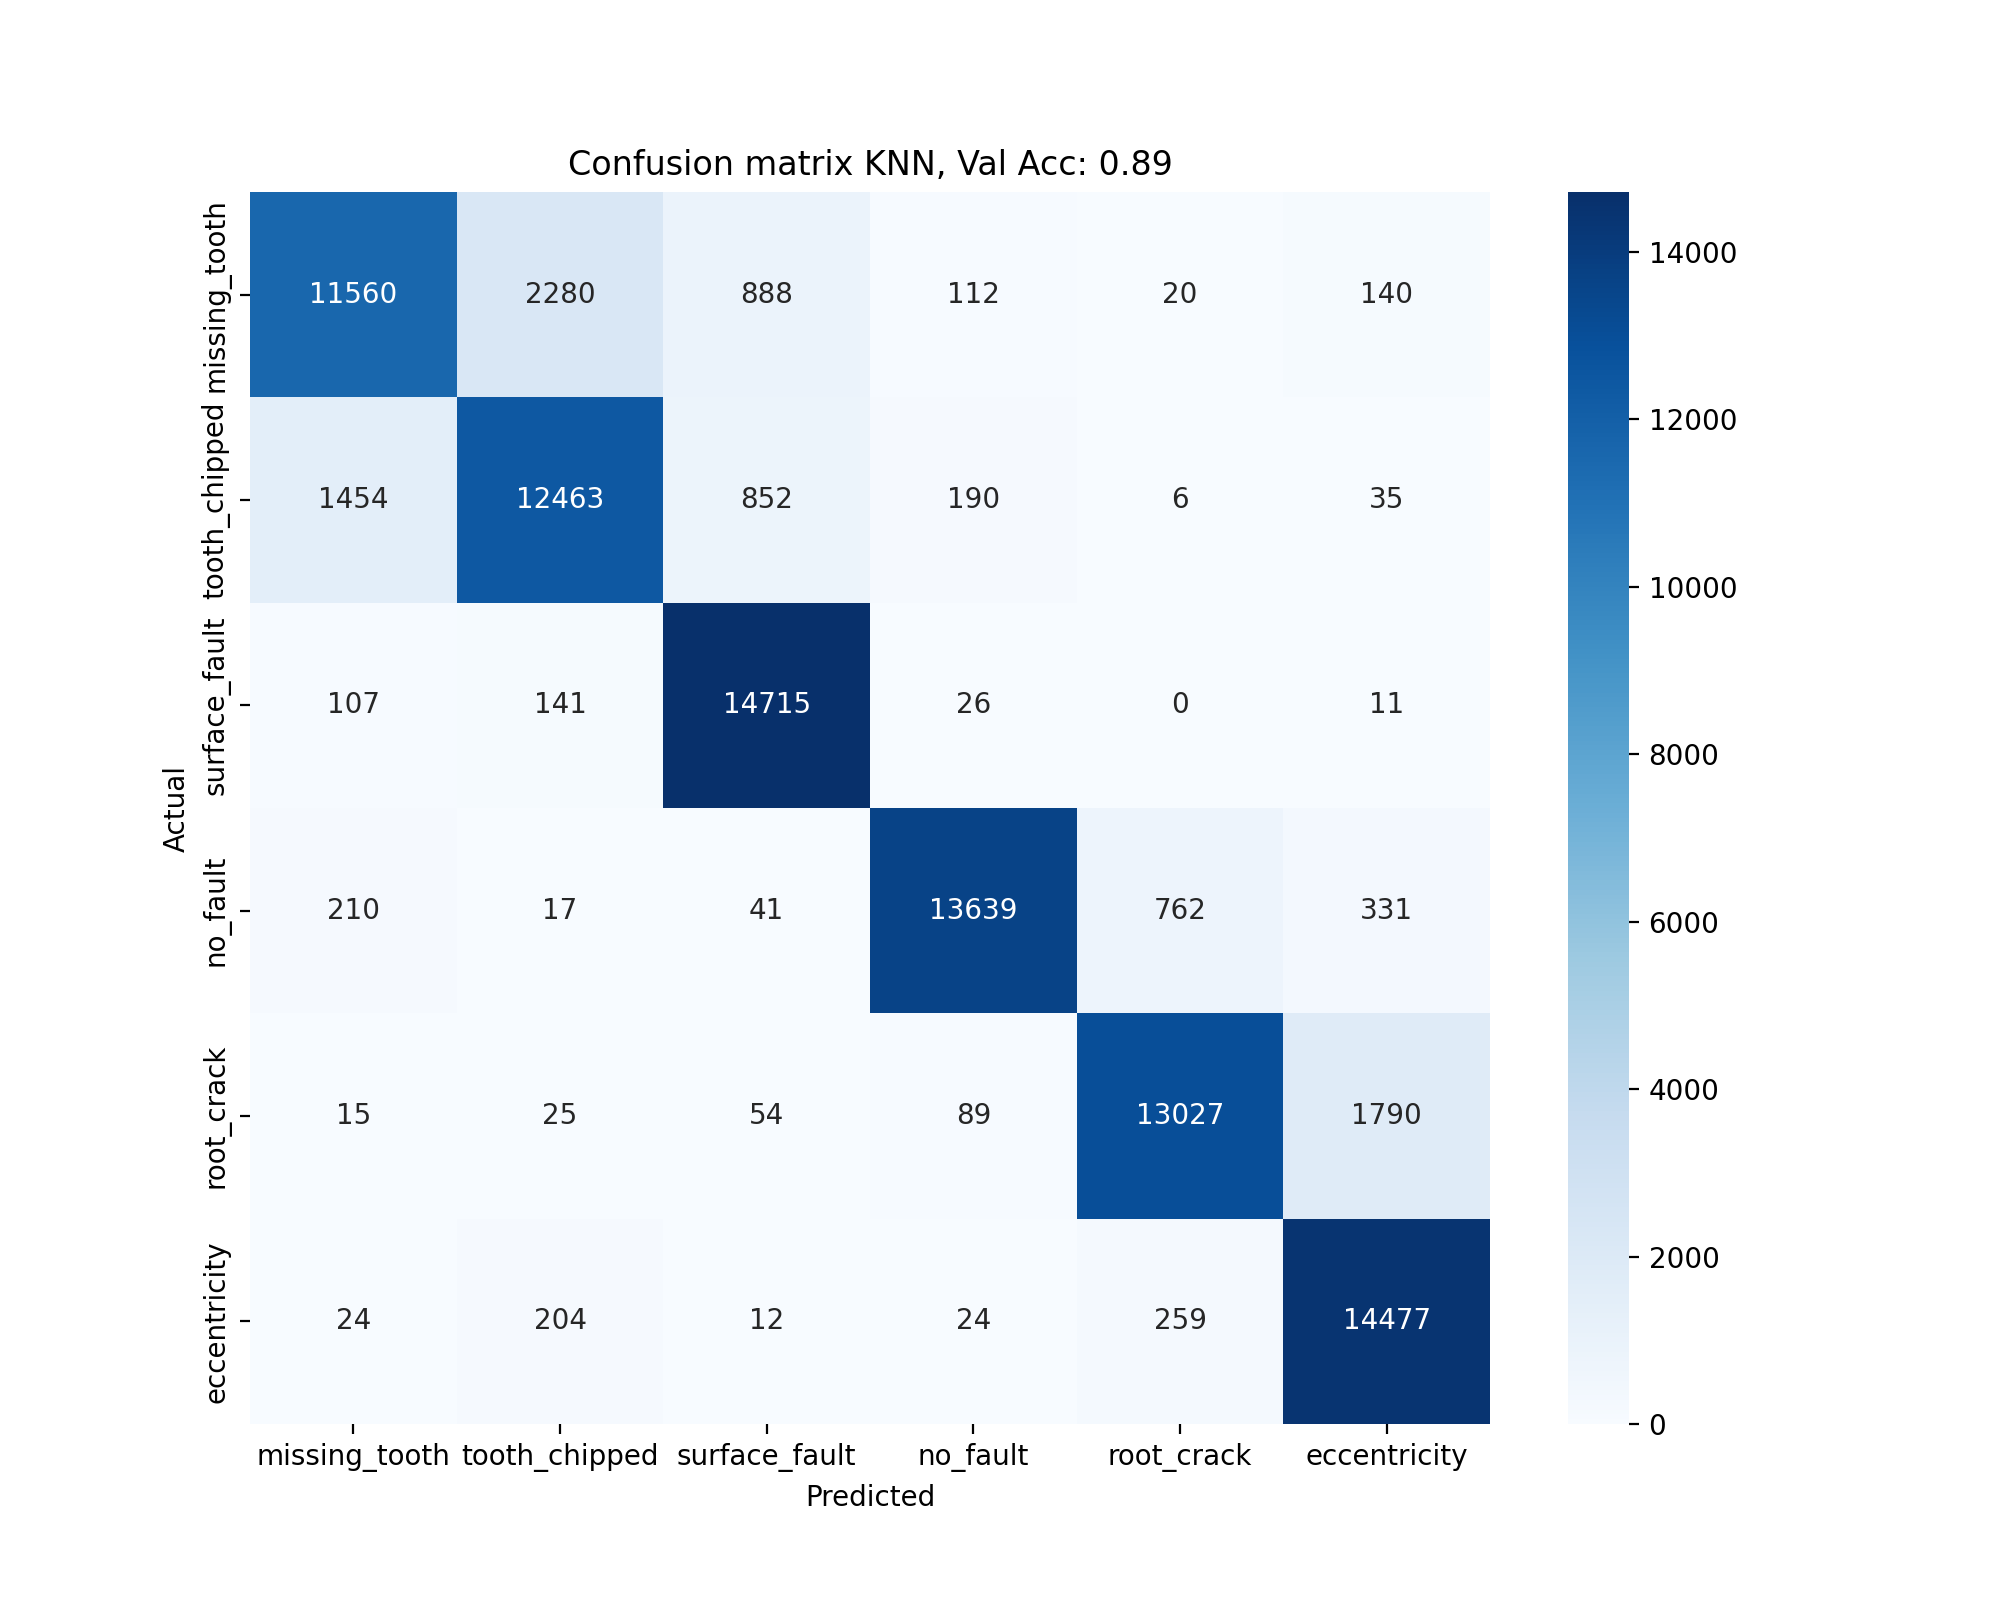

In [ ]:
# Calculate the confusion matrix
cm = confusion_matrix(y_val, val_pred_xgb)

# Trasnform classes from numerical to names using state_expected_keys
predicted_names = [mapping_dict[label] for label in best_knn_model.classes_]

# Show confnusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=predicted_names, yticklabels=predicted_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion matrix KNN, Val Acc: {val_accuracy_xgb:.2f}')
plt.show()

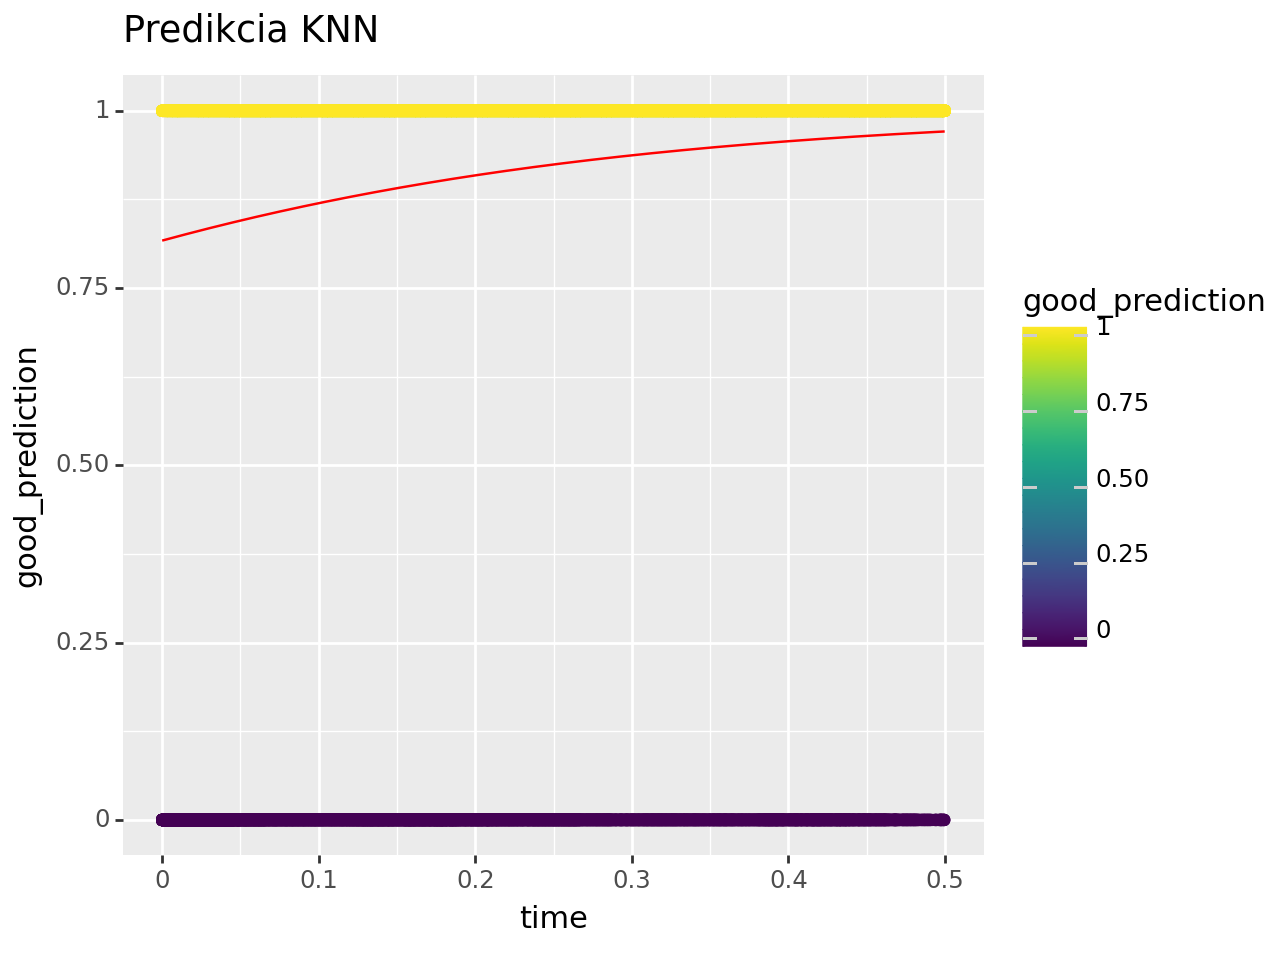

<Figure Size: (640 x 480)>

In [ ]:
dfer = y_val.reset_index(drop=True).to_frame()
dfer['time'] = X_val_not_scaled.time_normalized.reset_index(drop=True)
dfer['state'] = val_pred_knn
dfer['yval'] = y_val.reset_index(drop=True)
dfer['range'] = dfer.index
dfer['good_prediction'] = (dfer.state == dfer.yval).astype(int)

# Assuming 'time' is your feature and 'good_prediction' is the binary outcome
X = dfer[['time']].values  # Features need to be 2D for scikit-learn
y = dfer['good_prediction'].values  # Target variable

# Fit the logistic regression model
model = LogisticRegression()
model.fit(X, y)

# Generate a range of x-values for predictions
x_range = np.linspace(dfer['time'].min(), dfer['time'].max(), 300).reshape(-1, 1)

# Predict probabilities for the generated x-values
y_pred = model.predict_proba(x_range)[:, 1]  # Get probabilities for the positive class

from plotnine import ggplot, aes, geom_point, geom_line, ggtitle

# Original data points
original_plot = (ggplot(dfer, aes(x='time', y='good_prediction', color='good_prediction')) +
                 geom_point() +
                 ggtitle('Predikcia KNN'))

# Create a DataFrame for the logistic curve
logistic_df = pd.DataFrame({'time': x_range.flatten(), 'probability': y_pred})

# Add the logistic curve to the plot
logistic_plot = (original_plot +
                 geom_line(data=logistic_df, mapping=aes(x='time', y='probability'), color='red'))

logistic_plot


In [ ]:
# Random Forest
param_distributions_rf = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
}

# Setup the model
rf_model = RandomForestClassifier()
random_search_rf = RandomizedSearchCV(rf_model, param_distributions=param_distributions_rf, 
    n_iter=1,  
    scoring='accuracy',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1)

random_search_rf.fit(X_train, y_train)

# Pick the best model
best_rf_model = random_search_rf.best_estimator_
best_rf_model.fit(X_train, y_train)

# Predict the test set
y_pred = best_rf_model.predict(X_test)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
display(print("Accuracy:", accuracy))

# For LightGBM example
val_pred_rf = best_rf_model.predict(X_val)
val_accuracy_rf = accuracy_score(y_val, val_pred_rf)

# Save the model name, validation score, hyperparameters and train/test/validation distribution to the database
params_str = json.dumps(random_search_rf.best_params_)
conn = sqlite3.connect('model_results.db')
c = conn.cursor()
c.execute("INSERT INTO model_results VALUES (?, ?, ?, ?)", ('KNN', val_accuracy_rf, params_str, '80/20/1'))
conn.commit()

# Print the validation accuracy
print(f'Validation Accuracy for RandomForest: {val_accuracy_rf}')

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Accuracy: 0.9287333333333333


None

Validation Accuracy for RandomForest: 0.9366222222222222


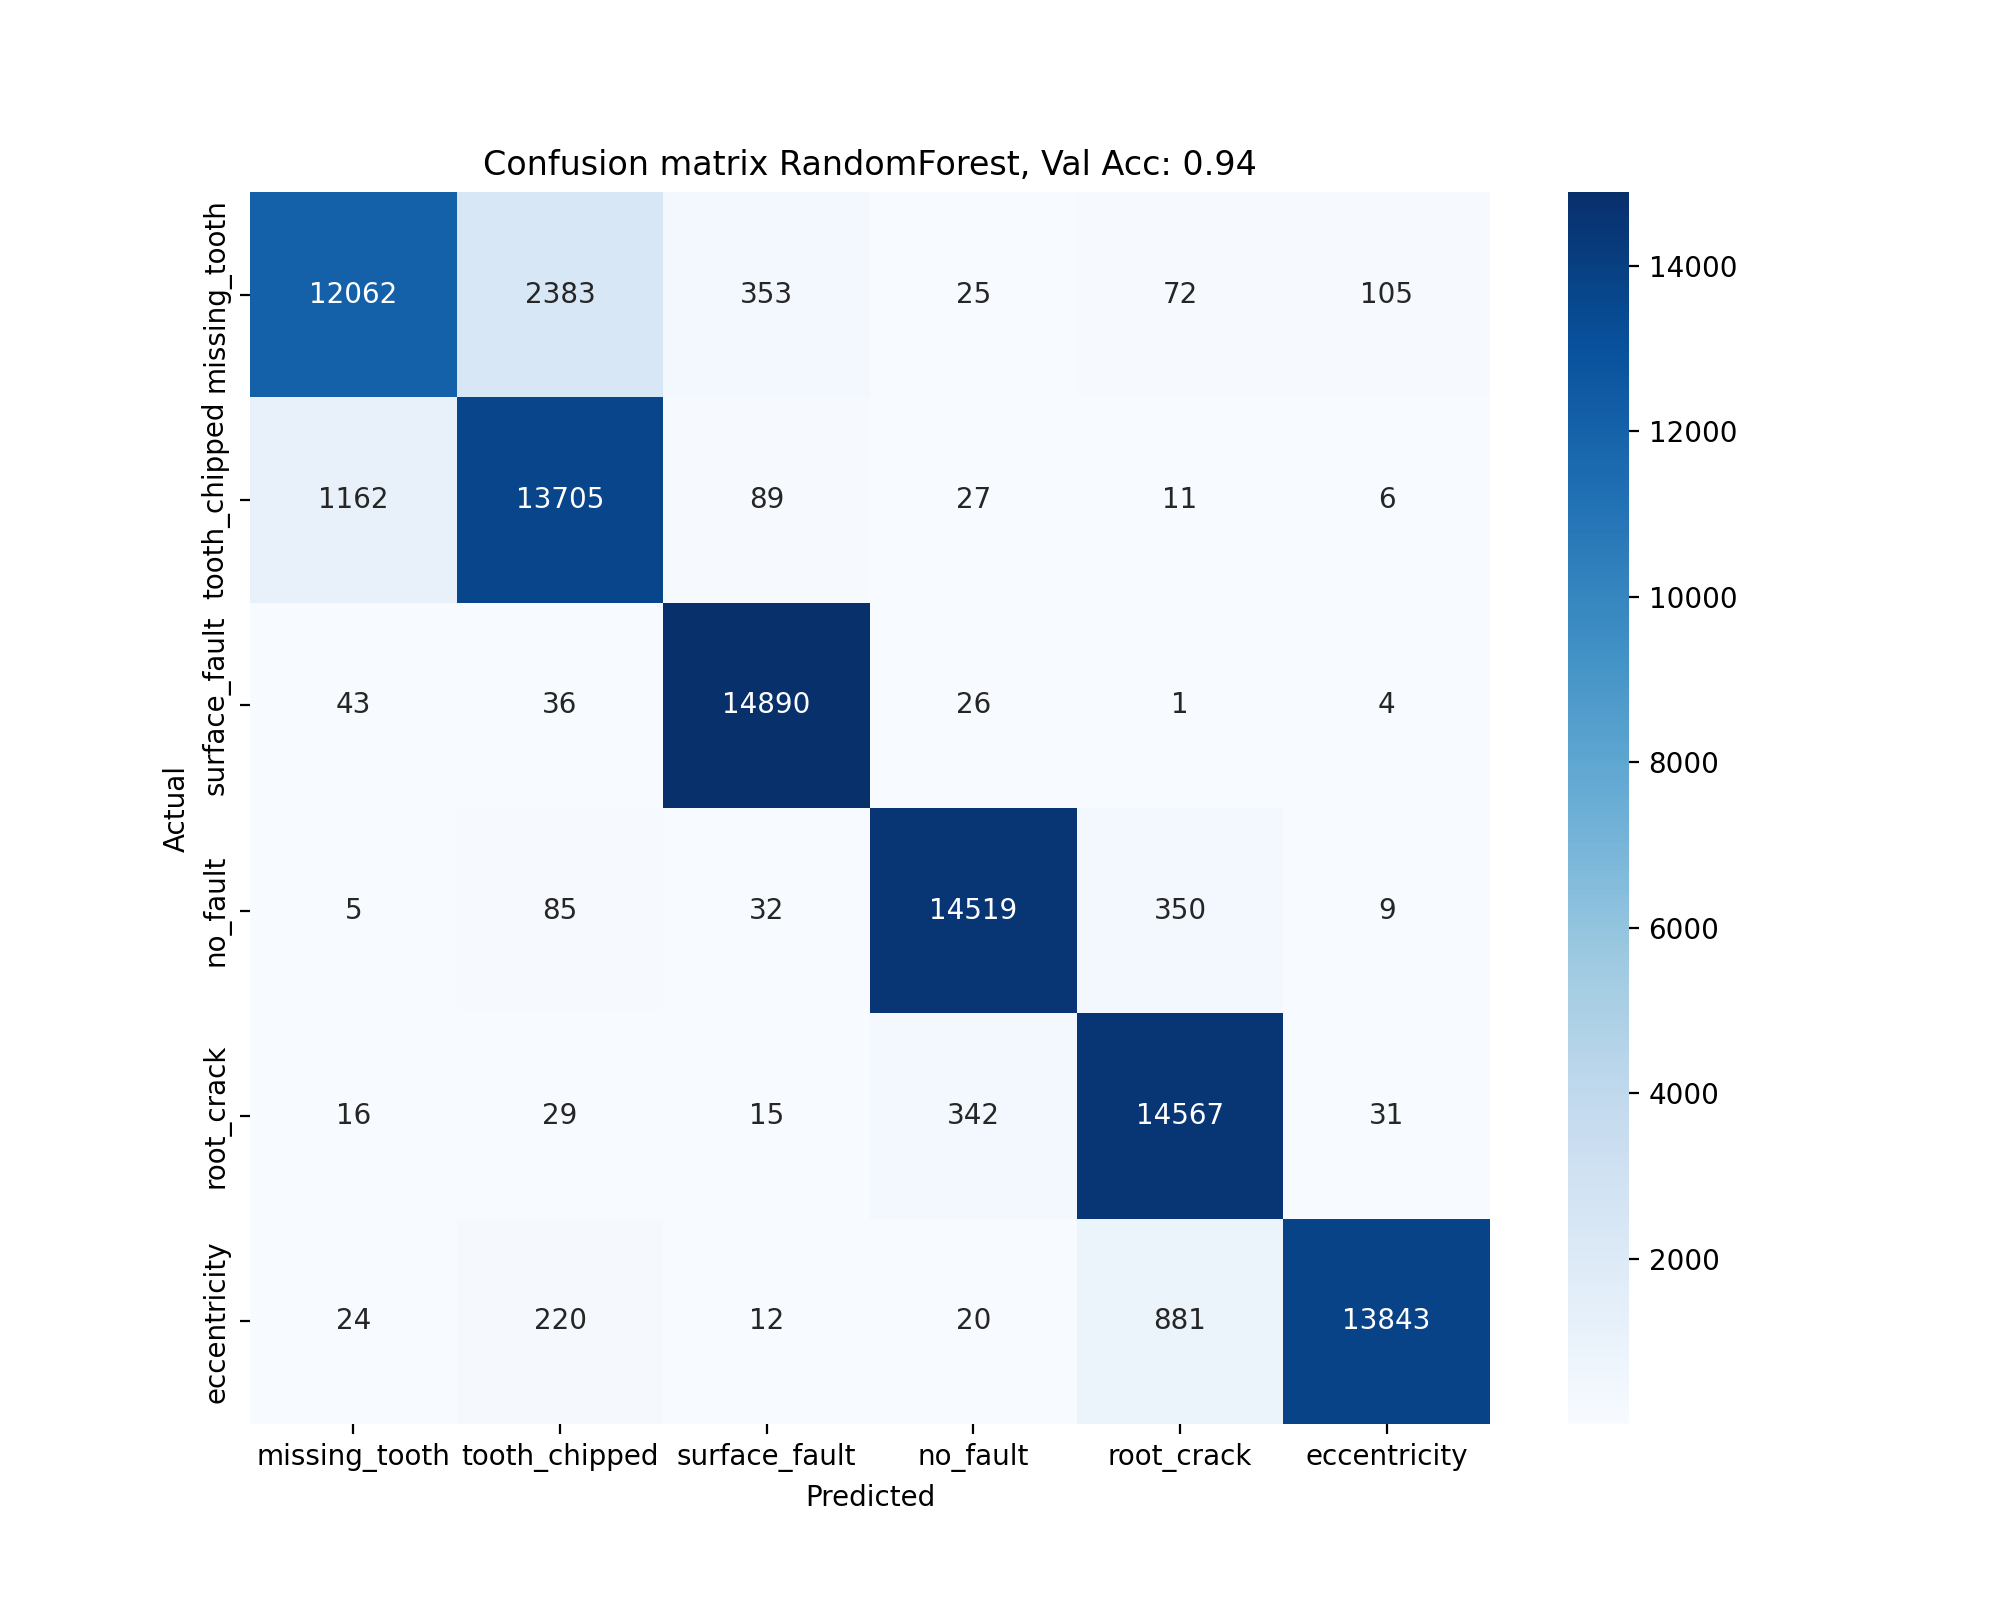

In [ ]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Trasnform classes from numerical to names using state_expected_keys
predicted_names = [mapping_dict[label] for label in best_rf_model.classes_]

# Show confnusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=predicted_names, yticklabels=predicted_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion matrix RandomForest, Val Acc: {val_accuracy_rf:.2f}')
plt.show()

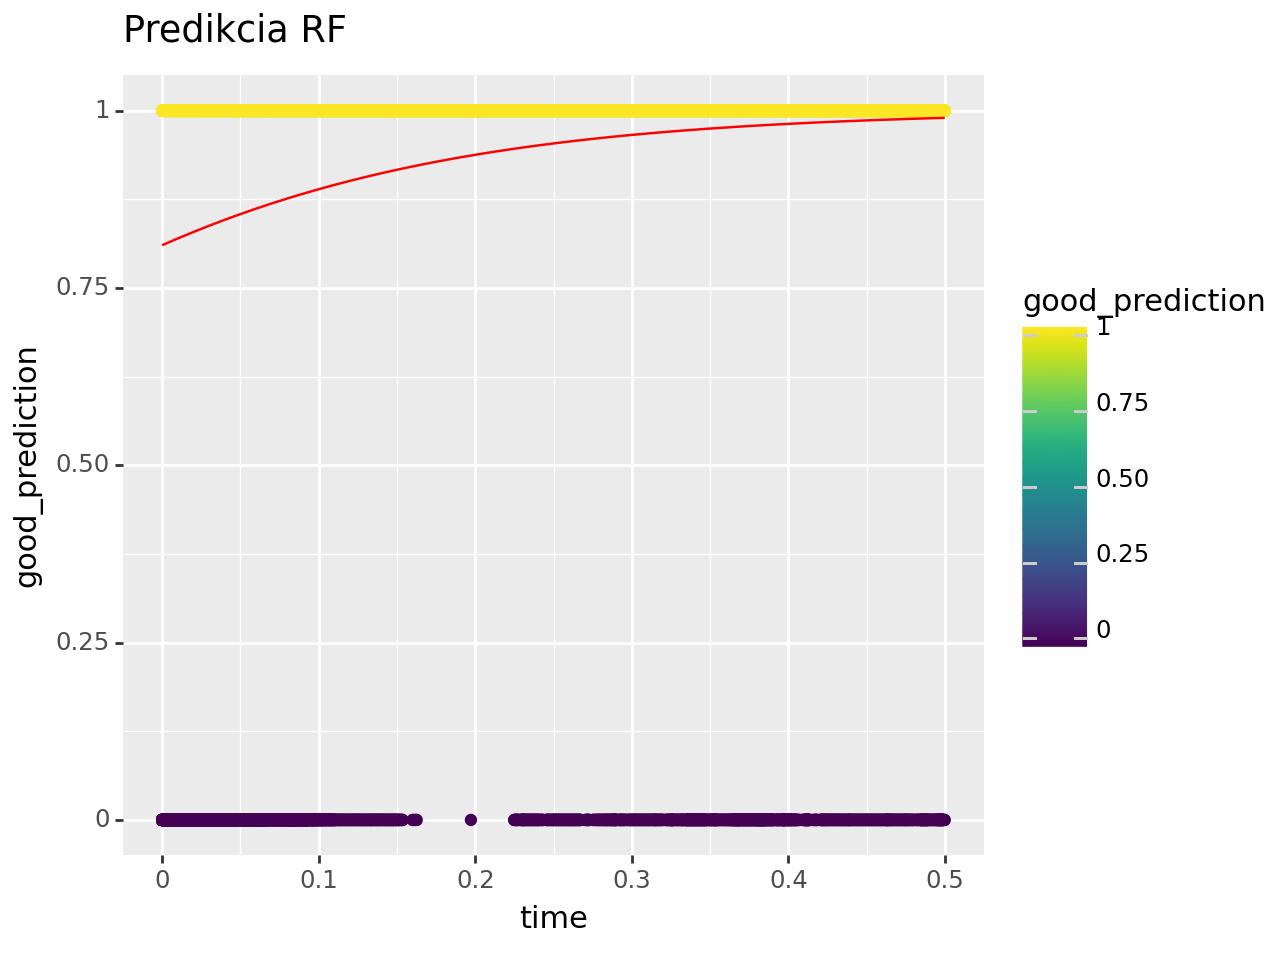

<Figure Size: (640 x 480)>

In [ ]:
dfer = y_val.reset_index(drop=True).to_frame()
dfer['time'] = X_val_not_scaled.time_normalized.reset_index(drop=True)
dfer['state'] = val_pred_rf
dfer['yval'] = y_val.reset_index(drop=True)
dfer['range'] = dfer.index
dfer['good_prediction'] = (dfer.state == dfer.yval).astype(int)

# Assuming 'time' is your feature and 'good_prediction' is the binary outcome
X = dfer[['time']].values  # Features need to be 2D for scikit-learn
y = dfer['good_prediction'].values  # Target variable

# Fit the logistic regression model
model = LogisticRegression()
model.fit(X, y)

# Generate a range of x-values for predictions
x_range = np.linspace(dfer['time'].min(), dfer['time'].max(), 300).reshape(-1, 1)

# Predict probabilities for the generated x-values
y_pred = model.predict_proba(x_range)[:, 1]  # Get probabilities for the positive class

from plotnine import ggplot, aes, geom_point, geom_line, ggtitle

# Original data points
original_plot = (ggplot(dfer, aes(x='time', y='good_prediction', color='good_prediction')) +
                 geom_point() +
                 ggtitle('Predikcia RF'))

# Create a DataFrame for the logistic curve
logistic_df = pd.DataFrame({'time': x_range.flatten(), 'probability': y_pred})

# Add the logistic curve to the plot
logistic_plot = (original_plot +
                 geom_line(data=logistic_df, mapping=aes(x='time', y='probability'), color='red'))

logistic_plot

In [ ]:
# Create a decision tree model for classification using the df dataset print the accuracy of the model
param_distributions_dt = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy'],
}

# Setup the model
dt_model = DecisionTreeClassifier()
random_search_dt = RandomizedSearchCV(dt_model, param_distributions=param_distributions_dt, 
    n_iter=1,  
    scoring='accuracy',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1)

random_search_dt.fit(X_train, y_train)

# Pick the best model
best_dt_model = random_search_dt.best_estimator_
best_dt_model.fit(X_train, y_train)

# Predict the test set
y_pred = best_dt_model.predict(X_test)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
display(print("Accuracy:", accuracy))

# For LightGBM example
val_pred_dt = best_dt_model.predict(X_val)
val_accuracy_dt = accuracy_score(y_val, val_pred_dt)

# Save the model name, validation score, hyperparameters and train/test/validation distribution to the database
params_str = json.dumps(random_search_dt.best_params_)
conn = sqlite3.connect('model_results.db')
c = conn.cursor()
c.execute("INSERT INTO model_results VALUES (?, ?, ?, ?)", ('DecisionTree', val_accuracy_dt, params_str, '80/20/1'))
conn.commit()

# Print the validation accuracy
print(f'Validation Accuracy for DecisionTree: {val_accuracy_dt}')

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Accuracy: 0.8845333333333333


None

Validation Accuracy for DecisionTree: 0.9000444444444444


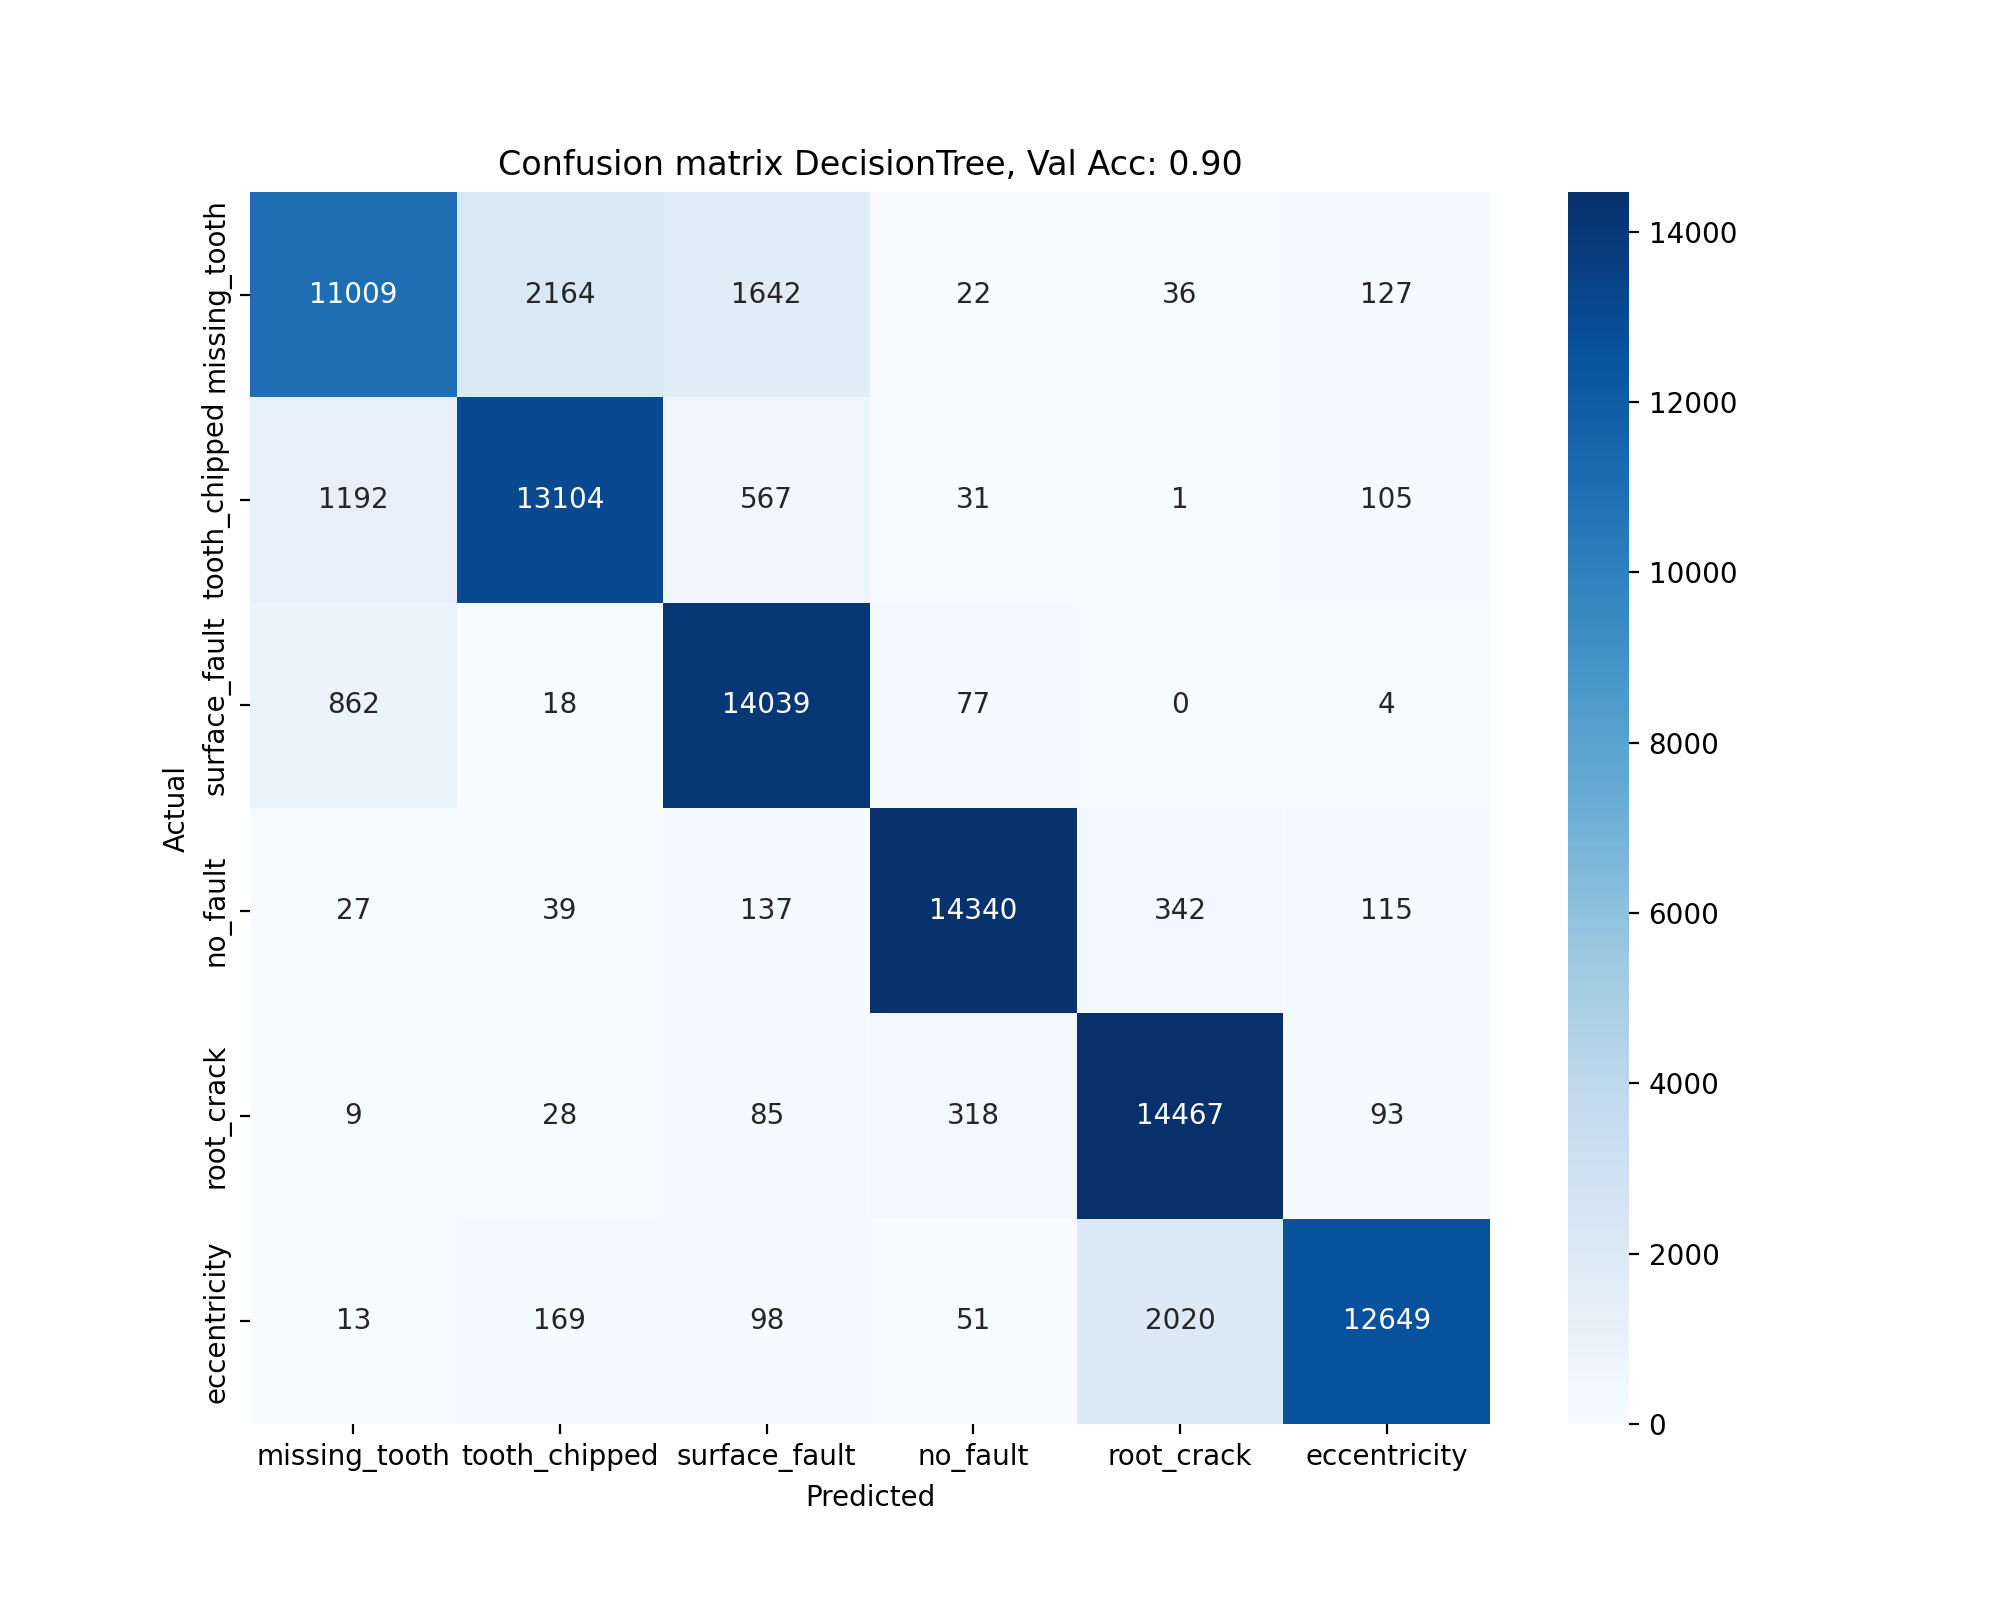

In [ ]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Trasnform classes from numerical to names using state_expected_keys
predicted_names = [mapping_dict[label] for label in best_dt_model.classes_]

# Show confnusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=predicted_names, yticklabels=predicted_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion matrix DecisionTree, Val Acc: {val_accuracy_dt:.2f}')
plt.show()

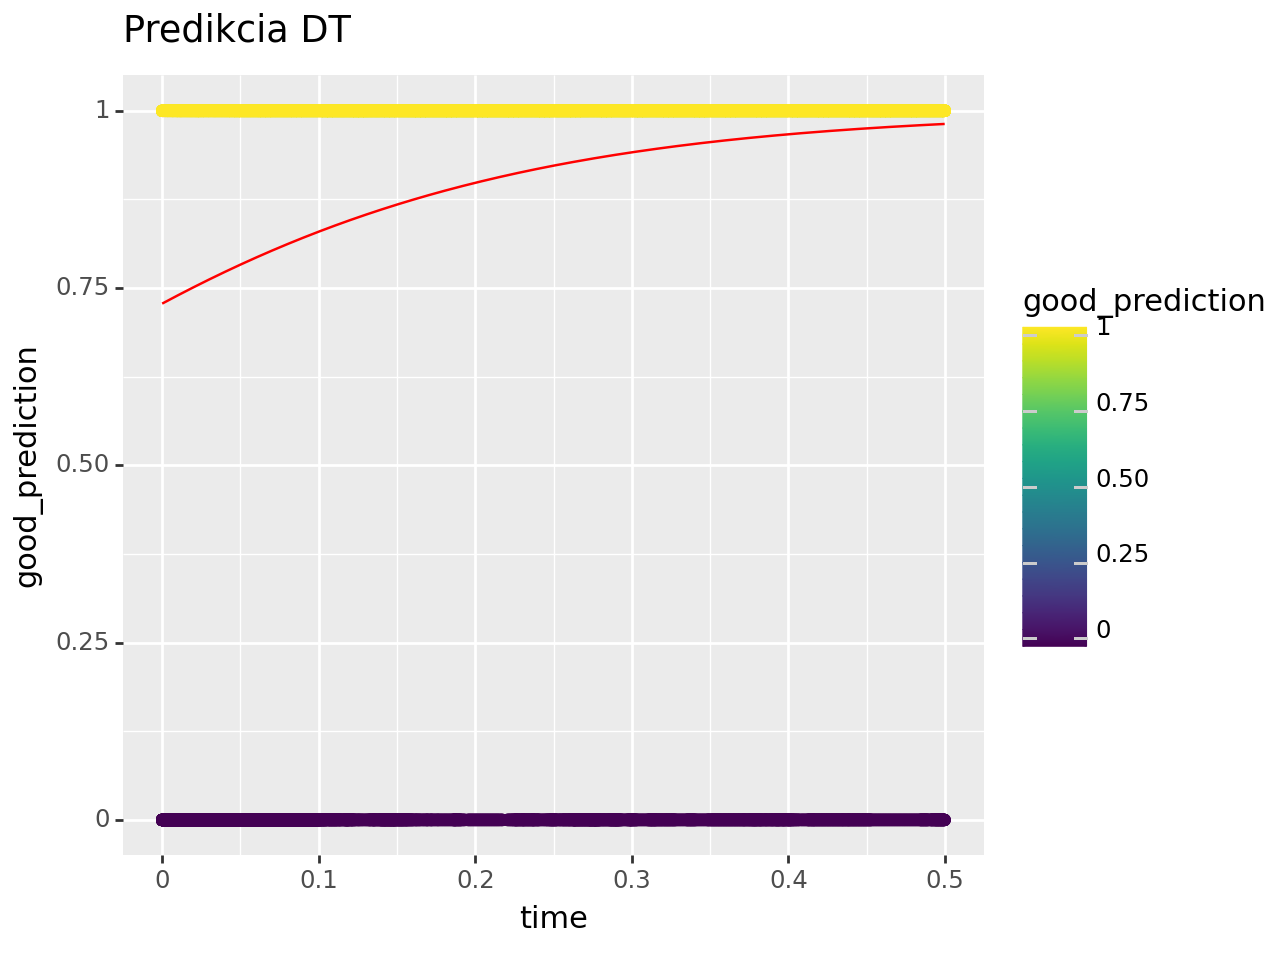

<Figure Size: (640 x 480)>

In [ ]:
dfer = y_val.reset_index(drop=True).to_frame()
dfer['time'] = X_val_not_scaled.time_normalized.reset_index(drop=True)
dfer['state'] = val_pred_dt
dfer['yval'] = y_val.reset_index(drop=True)
dfer['range'] = dfer.index
dfer['good_prediction'] = (dfer.state == dfer.yval).astype(int)

# Assuming 'time' is your feature and 'good_prediction' is the binary outcome
X = dfer[['time']].values  # Features need to be 2D for scikit-learn
y = dfer['good_prediction'].values  # Target variable

# Fit the logistic regression model
model = LogisticRegression()
model.fit(X, y)

# Generate a range of x-values for predictions
x_range = np.linspace(dfer['time'].min(), dfer['time'].max(), 300).reshape(-1, 1)

# Predict probabilities for the generated x-values
y_pred = model.predict_proba(x_range)[:, 1]  # Get probabilities for the positive class

from plotnine import ggplot, aes, geom_point, geom_line, ggtitle

# Original data points
original_plot = (ggplot(dfer, aes(x='time', y='good_prediction', color='good_prediction')) +
                 geom_point() +
                 ggtitle('Predikcia DT'))

# Create a DataFrame for the logistic curve
logistic_df = pd.DataFrame({'time': x_range.flatten(), 'probability': y_pred})

# Add the logistic curve to the plot
logistic_plot = (original_plot +
                 geom_line(data=logistic_df, mapping=aes(x='time', y='probability'), color='red'))

logistic_plot

In [ ]:
# Create SVM
param_distributions_svm = {
    'C': [0.1],
    'gamma': [0.01],
    'kernel': ['rbf'],
}

# Setup the model
svm_model = SVC()
random_search_svm = RandomizedSearchCV(svm_model, param_distributions=param_distributions_svm, 
    n_iter=1,  
    scoring='accuracy',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1)

random_search_svm.fit(X_train, y_train)

# Pick the best model
best_svm_model = random_search_svm.best_estimator_
best_svm_model.fit(X_train, y_train)

# Predict the test set
y_pred = best_svm_model.predict(X_test)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
display(print("Accuracy:", accuracy))

# For LightGBM example
val_pred_svm = best_svm_model.predict(X_val)
val_accuracy_svm = accuracy_score(y_val, val_pred_svm)

# Save the model name, validation score, hyperparameters and train/test/validation distribution to the database
params_str = json.dumps(random_search_svm.best_params_)
conn = sqlite3.connect('model_results.db')
c = conn.cursor()
c.execute("INSERT INTO model_results VALUES (?, ?, ?, ?)", ('SVM', val_accuracy_svm, params_str, '80/20/1'))
conn.commit()

# Print the validation accuracy
print(f'Validation Accuracy for SVM: {val_accuracy_svm}')

Fitting 3 folds for each of 1 candidates, totalling 3 fits


KeyboardInterrupt: 

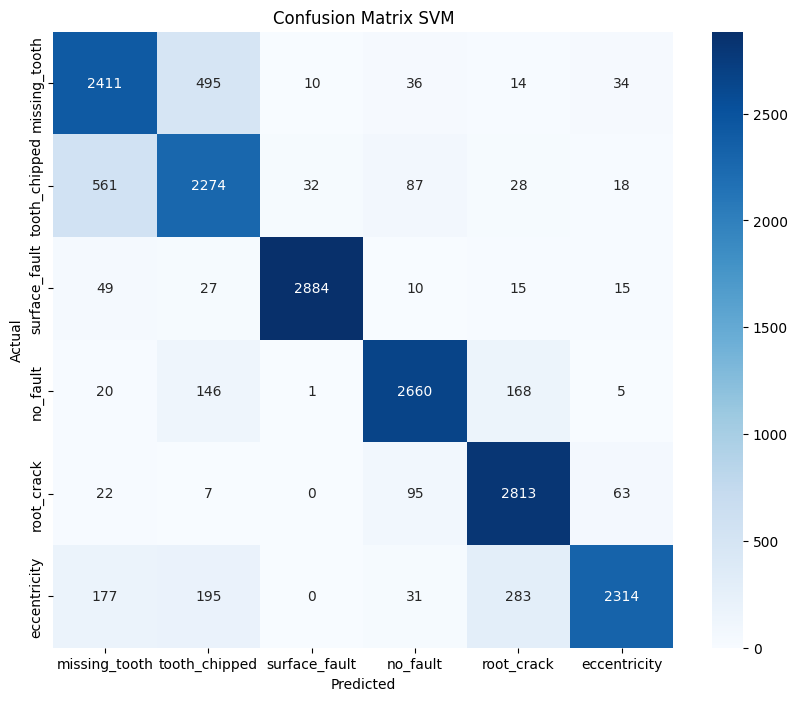

In [ ]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Trasnform classes from numerical to names using state_expected_keys
predicted_names = [mapping_dict[label] for label in best_svm_model.classes_]

# Show confnusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=predicted_names, yticklabels=predicted_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion matrix SVM, Val Acc: {val_accuracy_svm:.2f}')
plt.show()

In [ ]:
dfer = y_val.reset_index(drop=True).to_frame()
dfer['time'] = X_val_not_scaled.time_normalized.reset_index(drop=True)
dfer['state'] = val_pred_svm
dfer['yval'] = y_val.reset_index(drop=True)
dfer['range'] = dfer.index
dfer['good_prediction'] = (dfer.state == dfer.yval).astype(int)

# Assuming 'time' is your feature and 'good_prediction' is the binary outcome
X = dfer[['time']].values  # Features need to be 2D for scikit-learn
y = dfer['good_prediction'].values  # Target variable

# Fit the logistic regression model
model = LogisticRegression()
model.fit(X, y)

# Generate a range of x-values for predictions
x_range = np.linspace(dfer['time'].min(), dfer['time'].max(), 300).reshape(-1, 1)

# Predict probabilities for the generated x-values
y_pred = model.predict_proba(x_range)[:, 1]  # Get probabilities for the positive class

from plotnine import ggplot, aes, geom_point, geom_line, ggtitle

# Original data points
original_plot = (ggplot(dfer, aes(x='time', y='good_prediction', color='good_prediction')) +
                 geom_point() +
                 ggtitle('Predikcia SVM'))

# Create a DataFrame for the logistic curve
logistic_df = pd.DataFrame({'time': x_range.flatten(), 'probability': y_pred})

# Add the logistic curve to the plot
logistic_plot = (original_plot +
                 geom_line(data=logistic_df, mapping=aes(x='time', y='probability'), color='red'))

logistic_plot

In [ ]:
# Create a multilayer perceptron model for classification using the df dataset print the accuracy of the model
param_distributions_mlp = {
    'hidden_layer_sizes': [(100, 50)],
    'activation': ['relu'],
    'solver': ['adam'],
    'alpha': [0.0001],
    'learning_rate': ['constant'],
}

# Setup the model
mlp_model = MLPClassifier()
random_search_mlp = RandomizedSearchCV(mlp_model, param_distributions=param_distributions_mlp, 
    n_iter=1,  
    scoring='accuracy',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1)

random_search_mlp.fit(X_train, y_train)

# Pick the best model
best_mlp_model = random_search_mlp.best_estimator_
best_mlp_model.fit(X_train, y_train)

# Predict the test set
y_pred = best_mlp_model.predict(X_test)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
display(print("Accuracy:", accuracy))

# For LightGBM example
val_pred_mlp = best_mlp_model.predict(X_val)
val_accuracy_mlp = accuracy_score(y_val, val_pred_mlp)

# Save the model name, validation score, hyperparameters and train/test/validation distribution to the database
params_str = json.dumps(random_search_mlp.best_params_)
conn = sqlite3.connect('model_results.db')
c = conn.cursor()
c.execute("INSERT INTO model_results VALUES (?, ?, ?, ?)", ('MLP', val_accuracy_mlp, params_str,  '80/20/1'))
conn.commit()

# Print the validation accuracy
print(f'Validation Accuracy for MLP: {val_accuracy_mlp}')

Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\rober\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.


Accuracy: 0.8864444444444445


None

Validation Accuracy for MLP: 0.8850333333333333


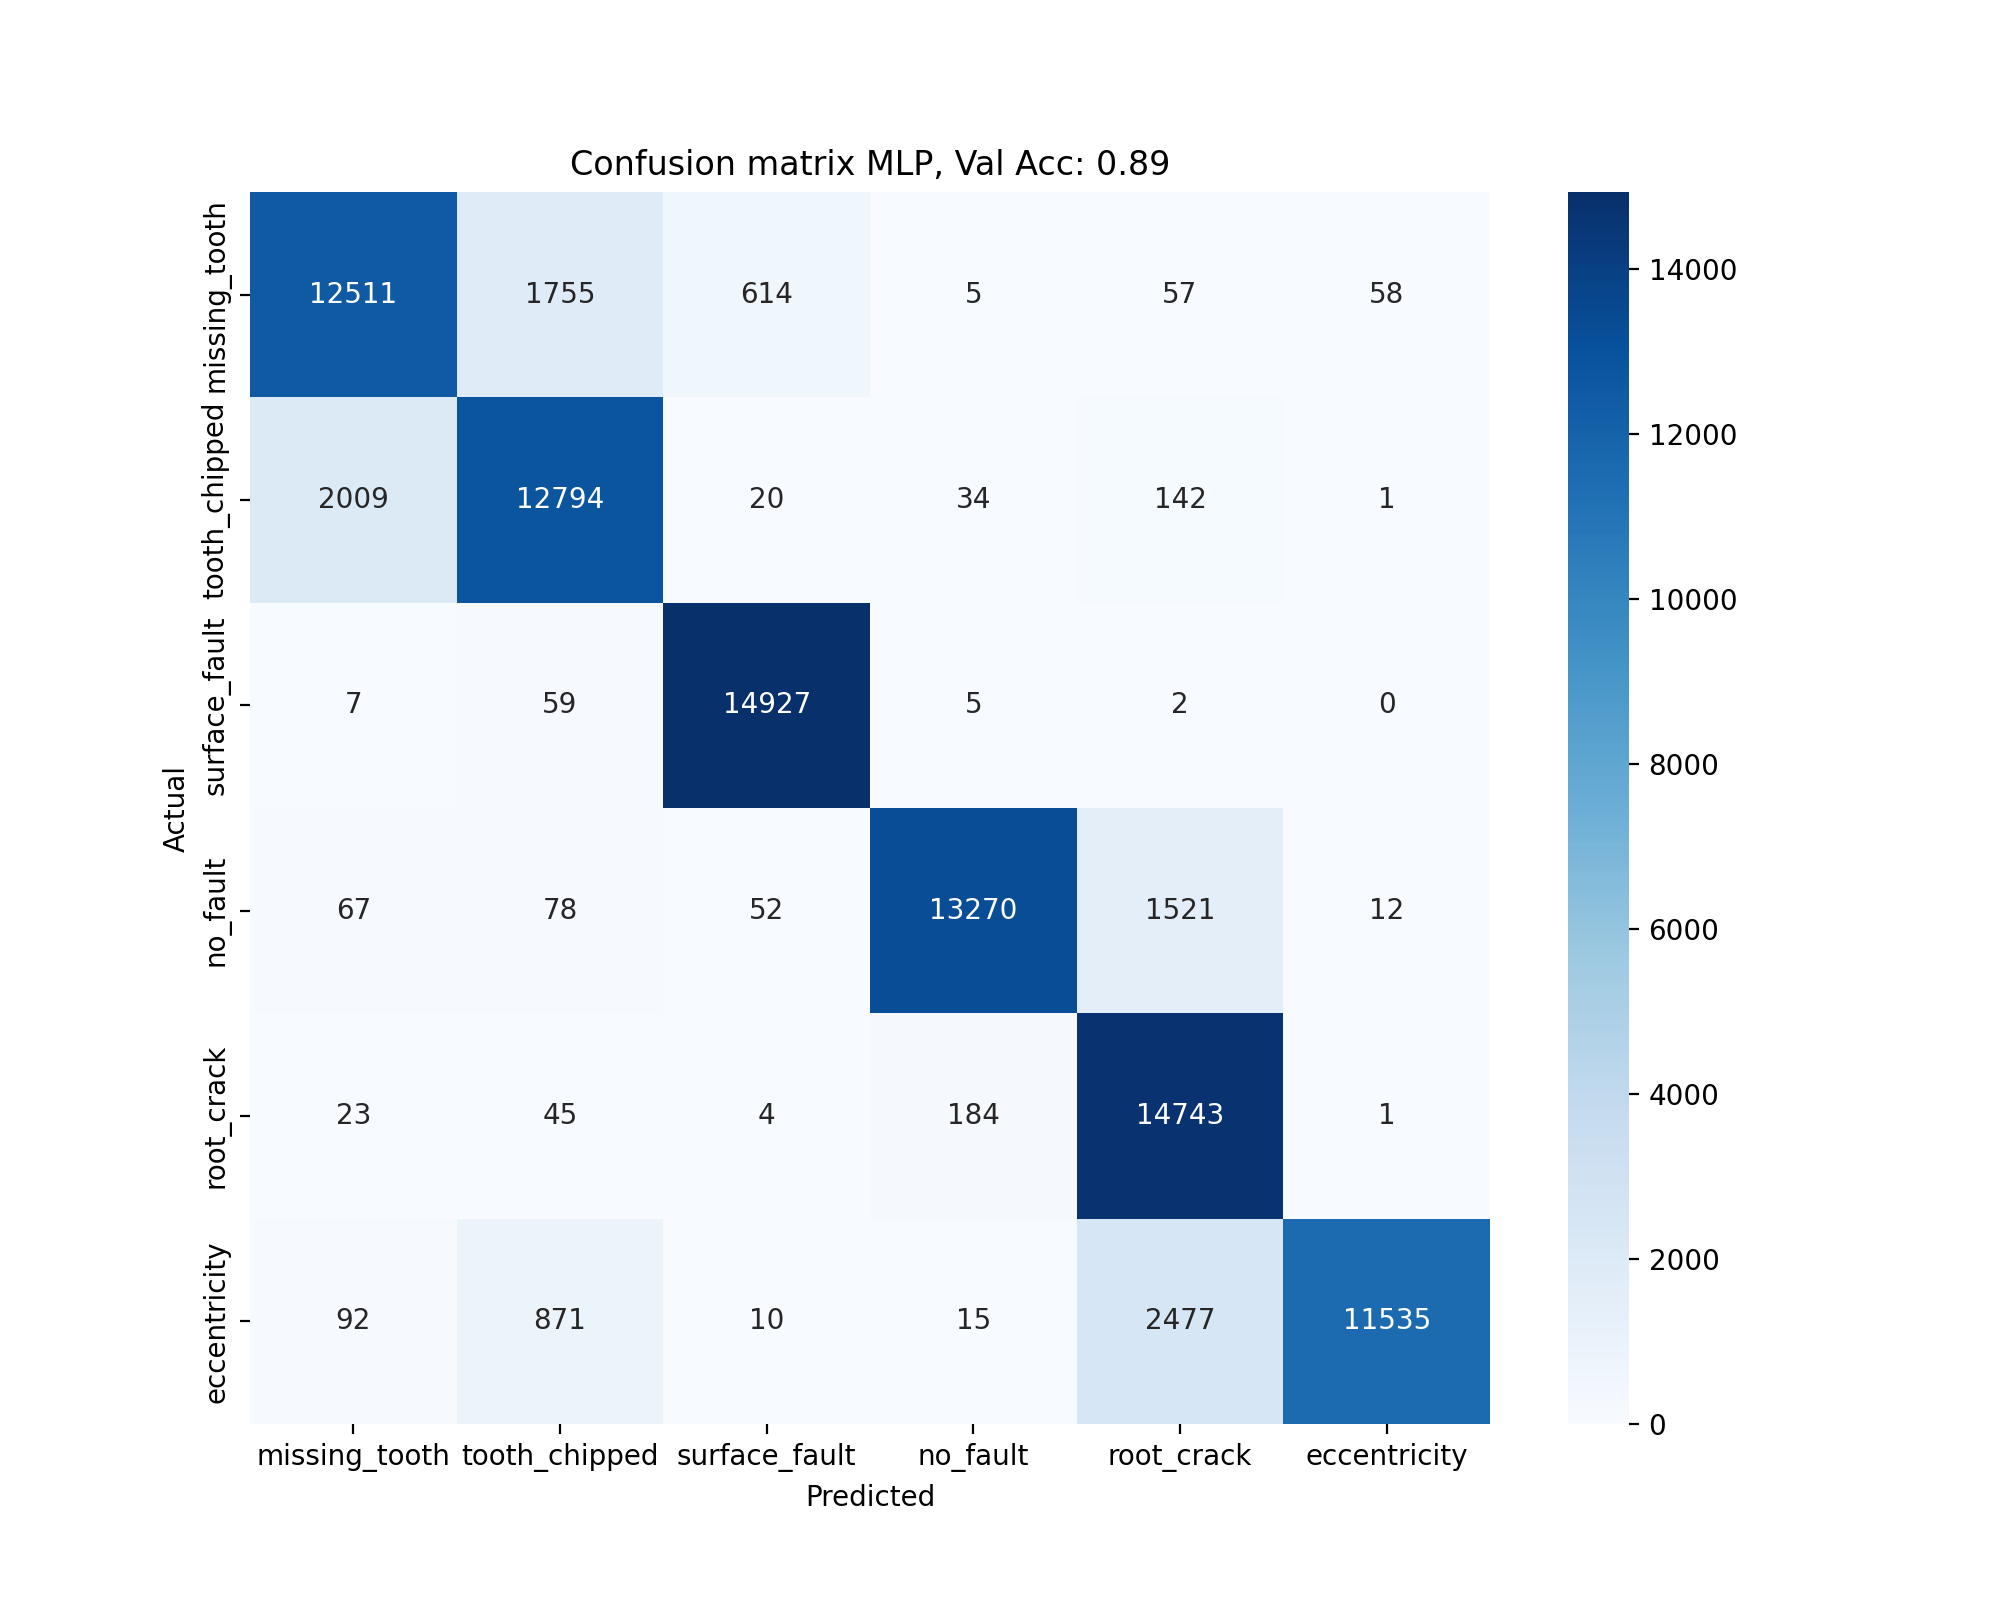

In [ ]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Trasnform classes from numerical to names using state_expected_keys
predicted_names = [mapping_dict[label] for label in best_mlp_model.classes_]

# Show confnusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=predicted_names, yticklabels=predicted_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion matrix MLP, Val Acc: {val_accuracy_mlp:.2f}')
plt.show()

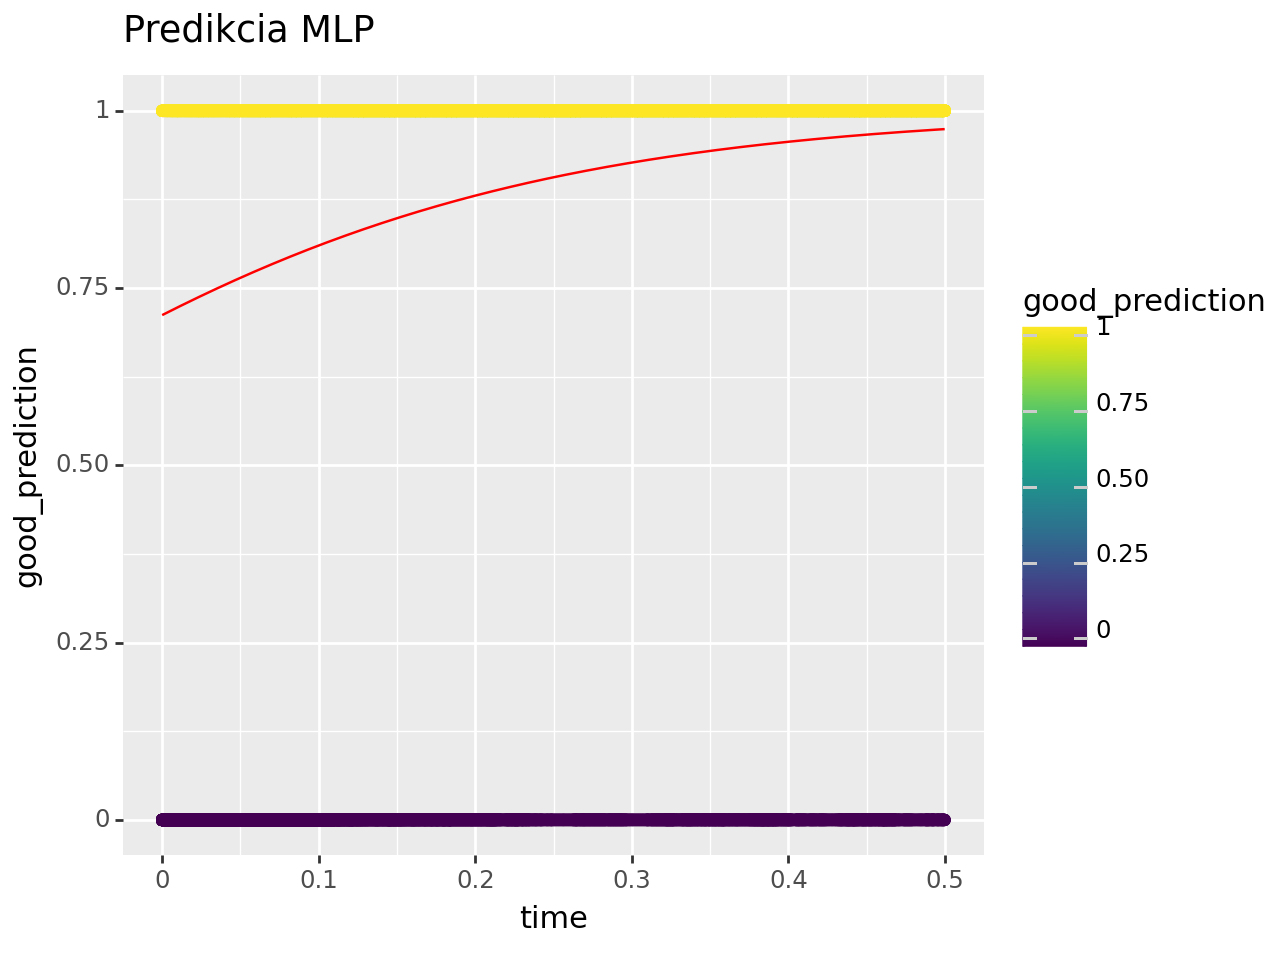

<Figure Size: (640 x 480)>

In [ ]:
dfer = y_val.reset_index(drop=True).to_frame()
dfer['time'] = X_val_not_scaled.time_normalized.reset_index(drop=True)
dfer['state'] = val_pred_mlp
dfer['yval'] = y_val.reset_index(drop=True)
dfer['range'] = dfer.index
dfer['good_prediction'] = (dfer.state == dfer.yval).astype(int)

# Assuming 'time' is your feature and 'good_prediction' is the binary outcome
X = dfer[['time']].values  # Features need to be 2D for scikit-learn
y = dfer['good_prediction'].values  # Target variable

# Fit the logistic regression model
model = LogisticRegression()
model.fit(X, y)

# Generate a range of x-values for predictions
x_range = np.linspace(dfer['time'].min(), dfer['time'].max(), 300).reshape(-1, 1)

# Predict probabilities for the generated x-values
y_pred = model.predict_proba(x_range)[:, 1]  # Get probabilities for the positive class

from plotnine import ggplot, aes, geom_point, geom_line, ggtitle

# Original data points
original_plot = (ggplot(dfer, aes(x='time', y='good_prediction', color='good_prediction')) +
                 geom_point() +
                 ggtitle('Predikcia MLP'))

# Create a DataFrame for the logistic curve
logistic_df = pd.DataFrame({'time': x_range.flatten(), 'probability': y_pred})

# Add the logistic curve to the plot
logistic_plot = (original_plot +
                 geom_line(data=logistic_df, mapping=aes(x='time', y='probability'), color='red'))

logistic_plot


In [ ]:
# SARIMA, LSTM, GRU, CNN-LSTM, TCN, transformers Training Time, Feature Importance